# Analyzing Key Factors in COVID-19 Outcomes by Country
Dataset: Our world in COVID-19
https://github.com/owid/covid-19-data/raw/master/public/
- this dataset is an amalgamate of many government data sources and John Hopkins University Research Center
- Dataset Codebook is available at the above github link

## Project Purpose
- This project is to shed light on the different attributes that may affect COVID spread and fatalities
- The aim is to discover the important trends, and find the most important demographic factors through visual trend analysis
- Another goal of this project is to develop an ARIMA model to forecast cases and deaths for Canada for the next 30 days
- This project will heavily focus on visualizations and exploratory data analysis, with forecasting as the final component
- Note: the data is being updated everyday and some insights may change over time

In [243]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt
import itertools
import warnings
warnings.simplefilter('ignore')

#Visualization
#!pip install plotly_express
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling and evaluation
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

sns.set_style("darkgrid")

In [2]:
OWIDdf = pd.read_csv('https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv')

In [18]:
OWIDdfc = OWIDdf.copy()

In [19]:
OWIDdfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85989 entries, 0 to 85988
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               85989 non-null  object 
 1   continent                              81842 non-null  object 
 2   location                               85989 non-null  object 
 3   date                                   85989 non-null  object 
 4   total_cases                            83868 non-null  float64
 5   new_cases                              83866 non-null  float64
 6   new_cases_smoothed                     82865 non-null  float64
 7   total_deaths                           74172 non-null  float64
 8   new_deaths                             74330 non-null  float64
 9   new_deaths_smoothed                    82865 non-null  float64
 10  total_cases_per_million                83415 non-null  float64
 11  ne

- many non-null values; 59 columns; ~90k entries; 5 object and 53 float
- columns 43 and thereafter are non-time-series variables and are country-related factors or demographics

In [95]:
OWIDdfc.location.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Europe', 'European Union', 'Faeroe Islands', 'Falkland Islands',
       'Fij

Location labels include continents, world(average), unions.

# Data Cleaning

- due to the data being relatively recent, with varying underreporting rates by region, some data is unavailable
- some columns have less than 10000 non-null values but are still useful for visual analysis. ie. new vaccinations

In [6]:
OWIDdfc.describe()
#many nonsensical negative values like -min in new_deaths columns.

total_cases      new_cases  new_cases_smoothed  total_deaths  \
count  8.386800e+04   83866.000000        82865.000000  7.417200e+04   
mean   8.405676e+05    5848.995278         5845.808059  2.332387e+04   
std    5.809087e+06   36594.065064        36060.253979  1.380193e+05   
min    1.000000e+00  -74347.000000        -6223.000000  1.000000e+00   
25%    9.510000e+02       2.000000            7.000000  4.500000e+01   
50%    1.062700e+04      70.000000           86.429000  3.180000e+02   
75%    1.129305e+05     770.750000          801.714000  3.096000e+03   
max    1.539770e+08  905992.000000       826374.286000  3.223800e+06   

         new_deaths  new_deaths_smoothed  total_cases_per_million  \
count  74330.000000         82865.000000             83415.000000   
mean     139.459518           123.811801             10263.805344   
std      760.982678           698.337514             19631.081566   
min    -1918.000000          -232.143000                 0.001000   
25%        0.000000             0.000000               204.683000   
50%        2.000000             1.286000              1397.519000   
75%       18.000000            13.714000             10095.111000   
max    17906.000000         14435.714000            172341.940000   

       new_cases_per_million  new_cases_smoothed_per_million  \
count           83413.000000                    82417.000000   
mean               74.559320                       74.693212   
std               176.443607                      149.266268   
min             -2153.437000                     -276.825000   
25%                 0.191000                        1.164000   
50%                 7.692000                       10.151000   
75%                68.315000                       76.172000   
max              8652.658000                     2648.773000   

       total_deaths_per_million  ...  gdp_per_capita  extreme_poverty  \
count              73732.000000  ...    77788.000000     52949.000000   
mean                 228.594229  ...    19136.789804        13.354245   
std                  400.876961  ...    19826.913333        19.945026   
min                    0.001000  ...      661.240000         0.100000   
25%                    6.857000  ...     4466.507000         0.500000   
50%                   40.297500  ...    12951.839000         2.200000   
75%                  244.511500  ...    27216.445000        21.200000   
max                 2903.104000  ...   116935.600000        77.600000   

       cardiovasc_death_rate  diabetes_prevalence  female_smokers  \
count           78378.000000         79540.000000    61400.000000   
mean              257.835270             7.821881       10.519186   
std               118.785583             3.979217       10.402674   
min                79.370000             0.990000        0.100000   
25%               167.295000             5.290000        1.900000   
50%               242.648000             7.110000        6.300000   
75%               329.635000            10.080000       19.300000   
max               724.417000            30.530000       44.000000   

       male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
count  60495.000000            39387.000000                71515.000000   
mean      32.657261               50.909993                    3.029301   
std       13.475743               31.762892                    2.463329   
min        7.700000                1.188000                    0.100000   
25%       21.600000               20.859000                    1.300000   
50%       31.400000               49.839000                    2.400000   
75%       41.100000               83.241000                    3.861000   
max       78.100000               98.999000                   13.800000   

       life_expectancy  human_development_index  
count     81615.000000             78260.000000  
mean         73.163868                 0.727076  
std           7.549464                 0.150058  
min 

In [7]:
df = OWIDdfc.copy()
df.new_cases.min()

-74347.0

- negatives may be due to discrepancies in total_ columns as new_ columns are calculated from them

In [28]:
OWIDdfc.iloc[81487:,]

iso_code continent        location        date  total_cases  new_cases  \
81487      GBR    Europe  United Kingdom  2021-04-05    4376629.0     2831.0   
81488      GBR    Europe  United Kingdom  2021-04-06    4379033.0     2404.0   
81489      GBR    Europe  United Kingdom  2021-04-07    4381830.0     2797.0   
81490      GBR    Europe  United Kingdom  2021-04-08    4384954.0     3124.0   
81491      GBR    Europe  United Kingdom  2021-04-09    4380167.0    -4787.0   
...        ...       ...             ...         ...          ...        ...   
85984      ZWE    Africa        Zimbabwe  2021-04-30      38257.0       22.0   
85985      ZWE    Africa        Zimbabwe  2021-05-01      38260.0        3.0   
85986      ZWE    Africa        Zimbabwe  2021-05-02      38281.0       21.0   
85987      ZWE    Africa        Zimbabwe  2021-05-03      38293.0       12.0   
85988      ZWE    Africa        Zimbabwe  2021-05-04      38327.0       34.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
81487            3547.571      127106.0        28.0               35.571  ...   
81488            3309.429      127126.0        20.0               30.571  ...   
81489            3121.143      127171.0        45.0               30.857  ...   
81490            2915.286      127224.0        53.0               31.143  ...   
81491            1742.571      127284.0        60.0               32.286  ...   
...                   ...           ...         ...                  ...  ...   
85984              30.286        1567.0         0.0                1.571  ...   
85985              28.000        1568.0         1.0                1.714  ...   
85986              27.857        1570.0         2.0                1.857  ...   
85987              27.286        1573.0         3.0                1.857  ...   
85988              23.286        1574.0         1.0                1.286  ...   

       gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
81487       39753.244              0.2                122.137   
81488       39753.244              0.2                122.137   
81489       39753.244              0.2                122.137   
81490       39753.244              0.2                122.137   
81491       39753.244              0.2                122.137   
...               ...              ...                    ...   
85984        1899.775             21.4                307.846   
85985        1899.775             21.4                307.846   
85986        1899.775             21.4                307.846   
85987        1899.775             21.4                307.846   
85988        1899.775             21.4                307.846   

       diabetes_prevalence  female_smokers  male_smokers  \
81487                 4.28            20.0          24.7   
81488                 4.28            20.0          24.7   
81489                 4.28            20.0          24.7   
81490                 4.28            20.0          24.7   
81491                 4.28            20.0          24.7   
...                    ...             ...           ...   
85984                 1.82             1.6          30.7   
85985                 1.82             1.6          30.7   
85986                 1.82             1.6          30.7   
85987                 1.82             1.6          30.7   
85988                 1.82             1.6          30.7   

       handwashing_facilities  hospital_beds_per_thousand  life_expectancy  \
81487                     NaN                        2.54            81.32   
81488                     NaN                        2.54            81.32   
81489                     NaN                        2.54            81.32   
81490                     NaN                        2.54            81.32   
81491                     NaN                        2.54            81.32   
...                       ...                         ...              ...   
85984                  3

In [11]:
#date indexing
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [12]:
df_world = df[df.location=='World']
df = df[-df.location.isin(['World'])]
#world is the global average 

# Exploring the Data
- this dataset has non-time series variables at column 43 and afterward
- target variables are deaths and cases
    - note the difference in population scales, in which case total_deaths_per_million is used

[Text(0, 0.5, 'Deaths'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Global Daily Deaths Mar-2020 to Apr-2021')]

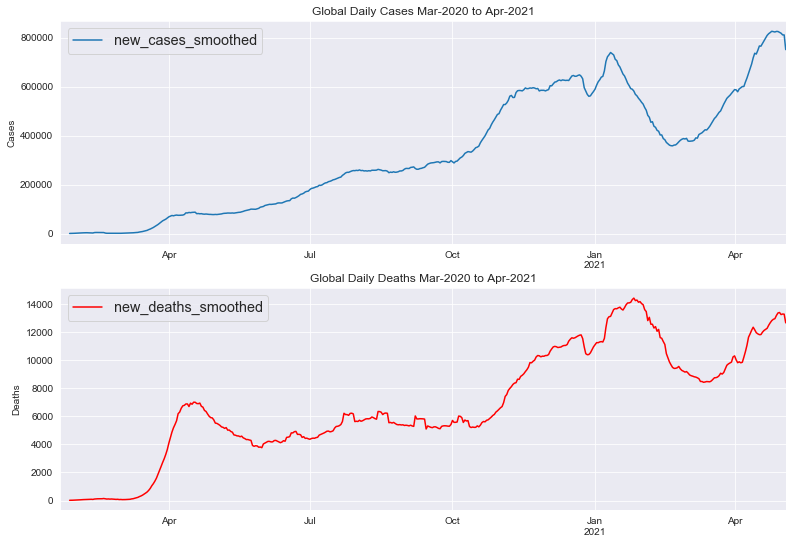

In [13]:
fig, ax = plt.subplots(2,1,figsize=(13,9))
for x, y in enumerate([df_world.new_cases_smoothed]):
    y.plot(ax=ax[0], linestyle='-')
for x, y in enumerate([df_world.new_deaths_smoothed]):
    y.plot(ax=ax[1], linestyle='-', color='r')
    
ax[0].legend(fontsize='x-large')
ax[0].set(xlabel = '', ylabel='Cases', title = 'Global Daily Cases Mar-2020 to Apr-2021')
ax[1].legend(fontsize='x-large')
ax[1].set(xlabel = '', ylabel='Deaths', title = 'Global Daily Deaths Mar-2020 to Apr-2021')

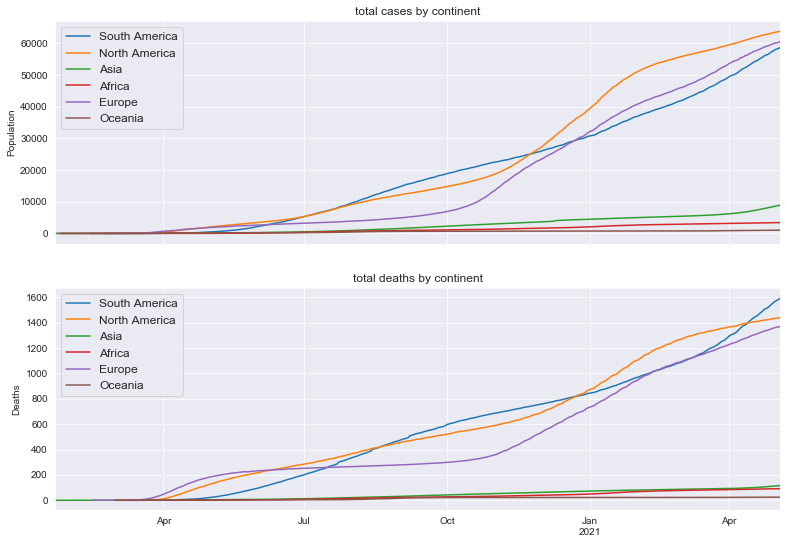

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(13,9), sharex=True)
continents = ['South America','North America','Asia','Africa','Europe','Oceania']#No Antarctica information available

for i in continents:
    for x, y in enumerate([df[df.location==i].total_cases_per_million]):
        y.plot(ax=ax[0], linestyle='-')
ax[0].set(xlabel = '', ylabel='Population', title = 'total cases by continent')  
#ax[0].annotate('Africa', xy=(df.index.max(),4000000), fontsize=12)
ax[0].legend(continents, fontsize='large')

for i in continents:
    for x, y in enumerate([df[df.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='-')
ax[1].set(xlabel = '', ylabel='Deaths', title = 'total deaths by continent') 
#ax[1].annotate('Africa', xy=(df.index.max(),110000), fontsize=12)
ax[1].legend(continents, loc='upper left',fontsize= 'large')

In [32]:
#lets take a look at Canada
odf_canada = df[df.location=='Canada']

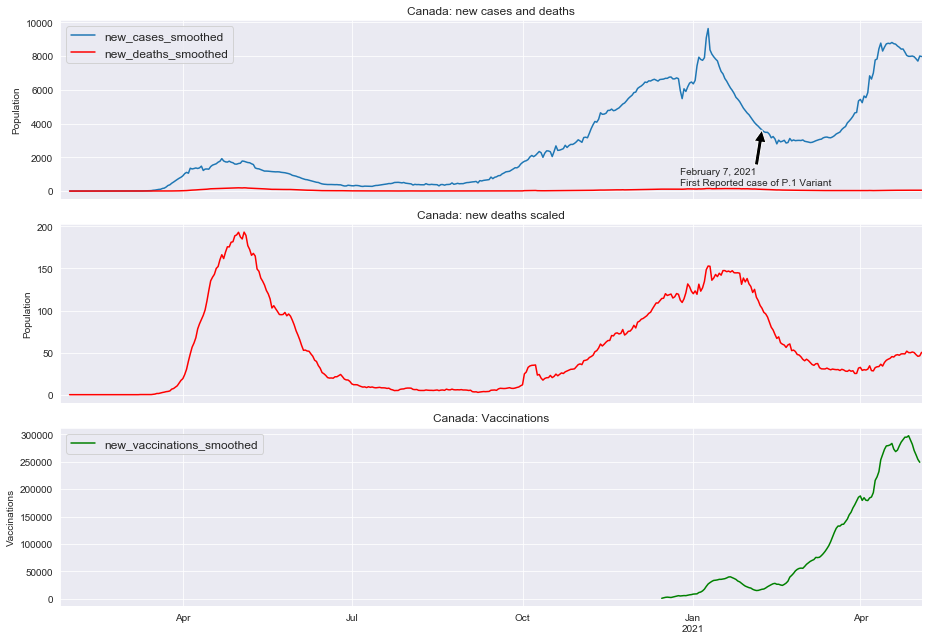

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(13,9), sharex=True)
for x, y in enumerate([odf_canada.new_cases_smoothed]):
    y.plot(ax=ax[0], linestyle='-')
for x, y in enumerate([odf_canada.new_deaths_smoothed]):
    y.plot(ax=ax[0], linestyle='-', color='r')
for x, y in enumerate([odf_canada.new_deaths_smoothed]):
    y.plot(ax=ax[1], linestyle='-', color='r')
for x, y in enumerate([odf_canada.new_vaccinations_smoothed]):
    y.plot(ax=ax[2], linestyle='-', color='g')  

ax[0].set(xlabel = '', ylabel='Population', title = 'Canada: new cases and deaths')
ax[1].set(xlabel = '', ylabel='Population', title = 'Canada: new deaths scaled')
ax[2].set(xlabel = '', ylabel='Vaccinations', title = 'Canada: Vaccinations')

ax[0].legend(loc='upper left', fontsize='large')
ax[2].legend(loc='upper left', fontsize='large')
ax[0].annotate('February 7, 2021\nFirst Reported case of P.1 Variant',
               xy=('2021-02-07', odf_canada.new_cases_smoothed['2021-02-07']),
               xycoords = 'data', xytext=('2020-12-25',1400),
               arrowprops=dict(facecolor='black'),
               horizontalalignment='left',
               verticalalignment='top')

plt.tight_layout()

- entering the 3rd wave of the pandemic in april which may have been affected by variants
- vaccine rollout still gaining

## Vaccinations vs Deaths
- the effects of large scale vaccinations will take a longer time-frame to visualize a clear effect

In [34]:
def timeplot(loc, case1, case2):
    fig, ax = plt.subplots(figsize=(14,7))
    for x, y in enumerate([df[df.location==loc][case1]]):
        y.plot(ax=ax, linestyle='-')
    for x, y in enumerate([df[df.location==loc][case2]]):
        y.plot(ax=ax, linestyle='-', color = 'r')
    #for x, y in enumerate([odf_canada.total_tests]):
    #    y.plot(ax=ax, linestyle='-')
    #for x, y in enumerate([odf_canada.total_vaccinations]):
    #    y.plot(ax=ax, linestyle='-')

    ax.set_title(''+case1+' vs '+case2, fontsize='xx-large')
    ax.legend(loc = 'upper left', fontsize='x-large')

In [35]:
def vtplot(case='Canada'):
    
    fig, host = plt.subplots(figsize=(12,6))
    par1 = host.twinx()
    par1.set_ylim(auto=True)

    host.set_ylabel('Total cases and vaccinations', fontsize=14)
    par1.set_ylabel('Total deaths', fontsize=14)

    for x, y in enumerate([df[df.location==case].total_cases.dropna()]):
        y.plot(ax=host, linestyle='-')
    for x, y in enumerate([df[df.location==case].total_deaths.dropna()]):
        y.plot(ax=par1, linestyle='--', color = 'r')
    for x, y in enumerate([df[df.location==case].total_vaccinations.dropna()]):
        y.plot(ax=host, linestyle='-', color='g')
    host.legend(labels=['total_cases','total_vaccinations'], loc='upper left', fontsize='x-large')
    par1.legend(labels=['total_deaths'], loc='upper right', fontsize='x-large')

    host.set_title(case, fontsize='xx-large')

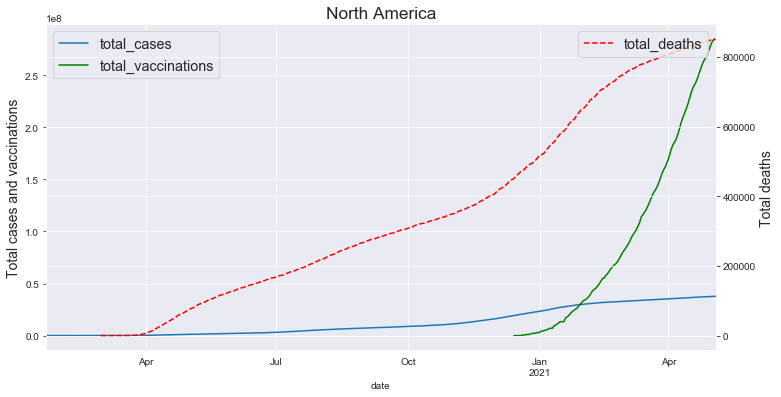

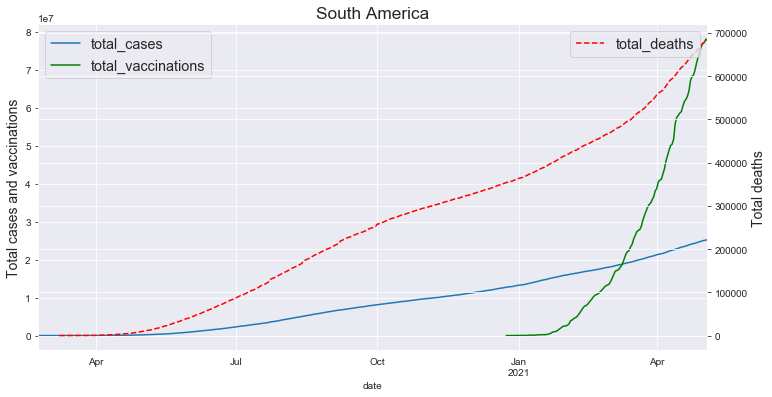

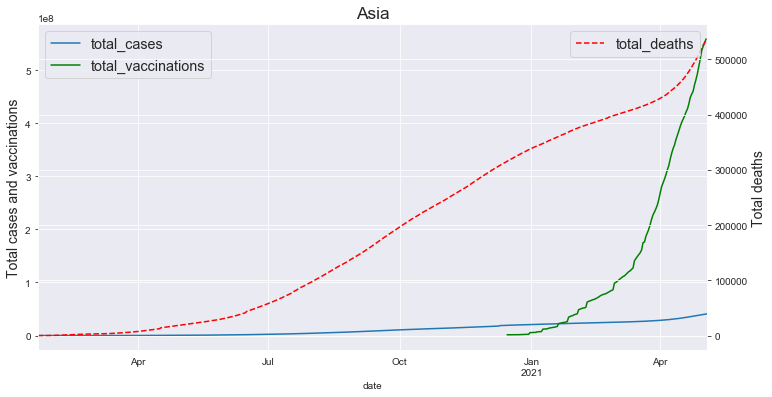

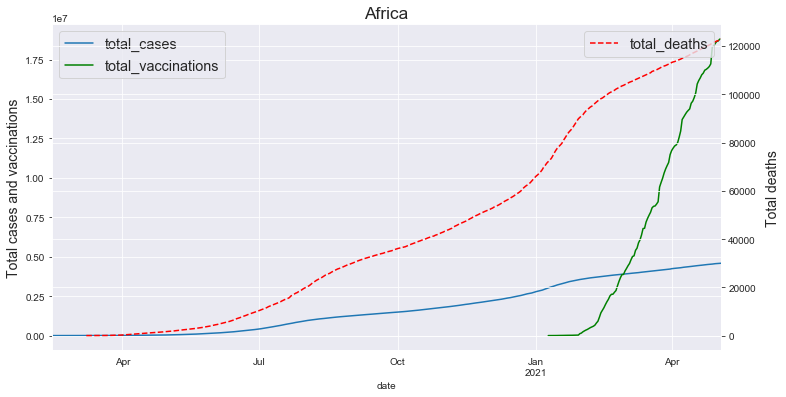

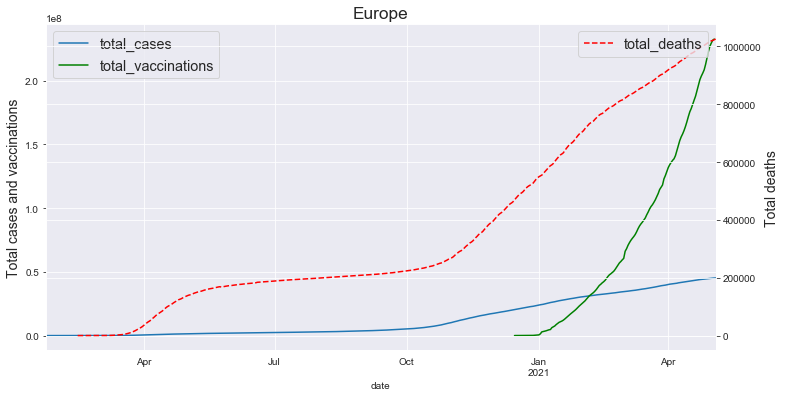

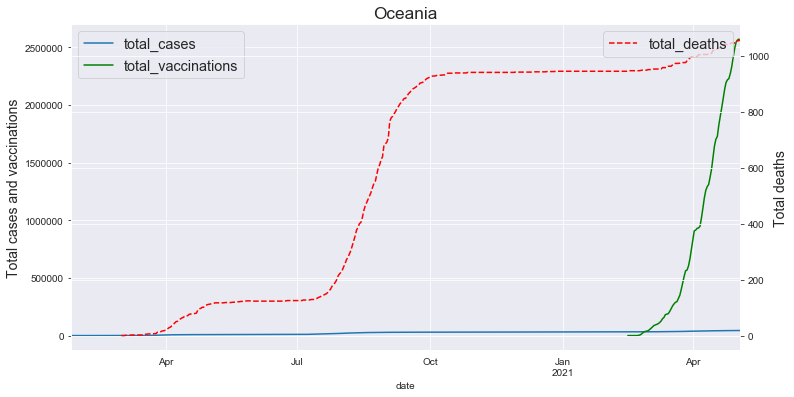

In [36]:
vtplot('North America')
vtplot('South America')
vtplot('Asia')
vtplot('Africa')
vtplot('Europe')
vtplot('Oceania')

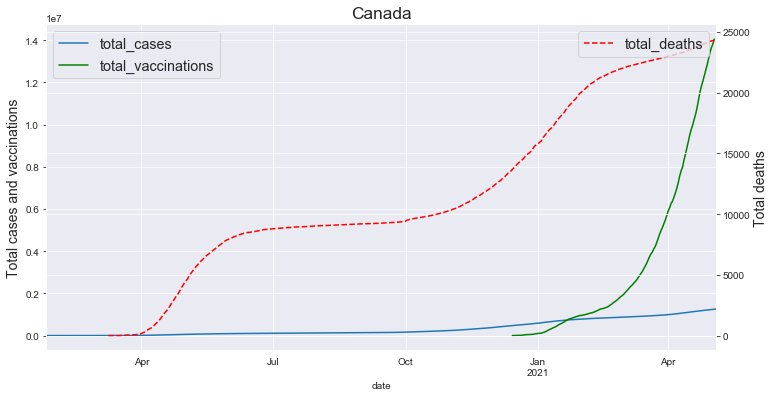

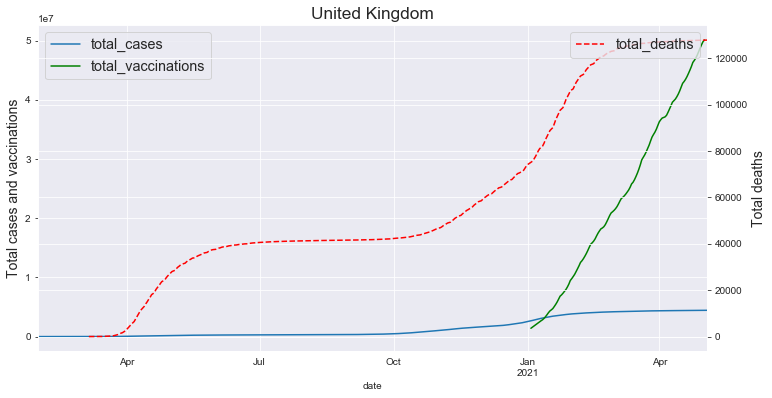

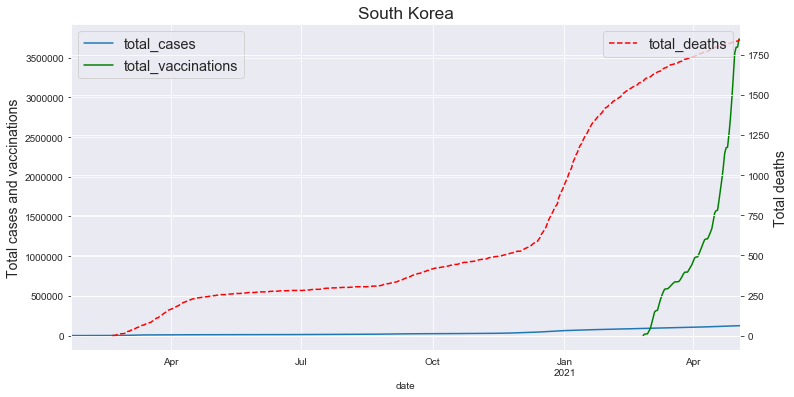

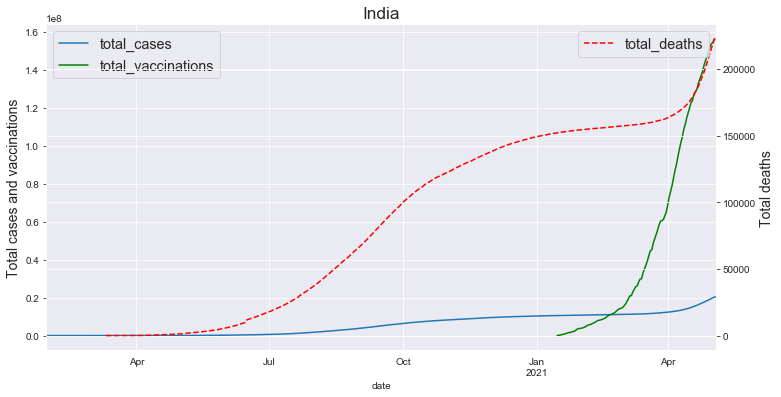

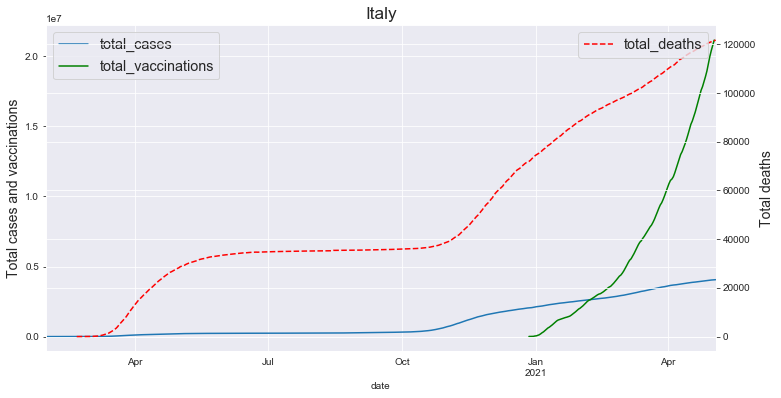

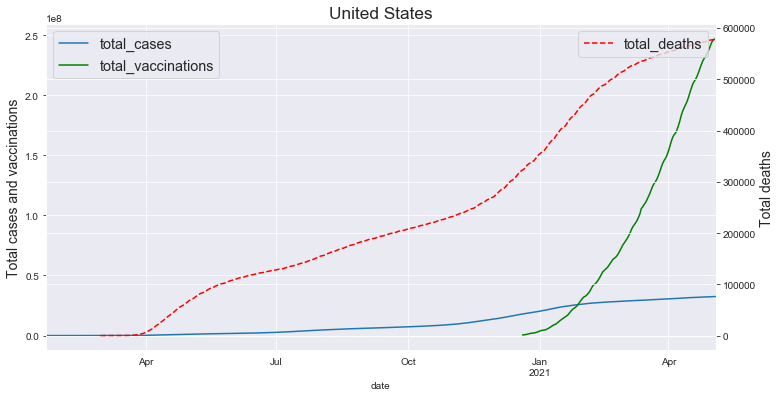

In [37]:
vtplot('Canada')
vtplot('United Kingdom')
vtplot('South Korea')
vtplot('India')
vtplot('Italy')
vtplot('United States')

- some cases of plateauing with higher vaccine count, especially in United States with a successful vaccine rollout
- As of May 1, 2021: cases in India are skyrocketing with the current wave and vaccine rollout cannot keep up with infection rate

## Chloropleth visualizations

In [39]:
odf_nocontinent = df[-df.location.isin(['World','European Union','North America',
                                        'South America','Asia','Africa','Europe','Oceania'])] # Removing Continents
#only take the max of each grouping
odf_totalcases = odf_nocontinent.groupby(odf_nocontinent['location']).agg(['max'])
odf_totalcases.columns = odf_totalcases.columns.droplevel(1)

## total_cases and total_deaths

In [40]:
fig = px.choropleth(odf_totalcases, locations='iso_code',
                    color='total_cases',
                    hover_name=odf_totalcases.index, 
                    color_continuous_scale=px.colors.sequential.deep)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

## total_deaths 
- similar to total_cases

In [41]:
fig = px.choropleth(odf_totalcases, locations='iso_code',
                    color='total_deaths',
                    hover_name=odf_totalcases.index, 
                    hover_data=['population_density','stringency_index','human_development_index'],
                    color_continuous_scale=px.colors.sequential.deep)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

## Life expectancy

In [42]:
fig = px.choropleth(odf_totalcases, locations='iso_code',
                    color=odf_totalcases.life_expectancy,
                    hover_name=odf_totalcases.index, 
                    color_continuous_scale=px.colors.diverging.curl,
                    color_continuous_midpoint=20)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

## Median Age
- median age may be an important factor in determining how fatal the virus will be on populations
- generally, populations with higher median age are at risk for a higher crude mortality, ie. Italy, Spain, Portugal
- however, countries like Japan, even while having one of the highest median ages do not have the same death rate within their population cohort

In [43]:
fig = px.choropleth(odf_totalcases, locations='iso_code',
                    color=odf_totalcases.median_age,
                    hover_name=odf_totalcases.index, 
                    color_continuous_scale=px.colors.diverging.curl,
                    color_continuous_midpoint=20)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

In [46]:
odf_ma40 = odf_totalcases[odf_totalcases.median_age>40]
odf_ma20 = odf_totalcases[odf_totalcases.median_age<20]

top5_ma = odf_totalcases.sort_values(by='median_age', ascending=False).head(5).index.tolist()
bot5_ma = odf_totalcases.sort_values(by='median_age', ascending=True).head(5).index.tolist()

Text(0.5, 0.98, 'Top 5 and Bottom 5 in Median Age')

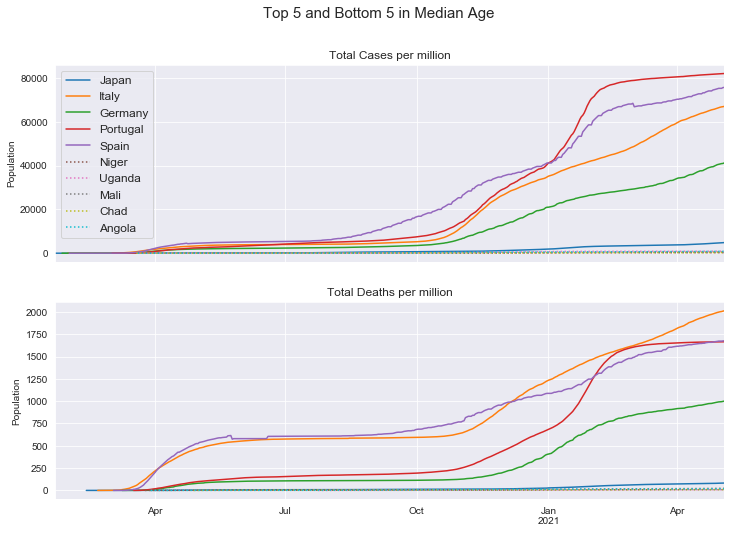

In [48]:
fig, ax = plt.subplots(2,1,figsize=(12,8), sharex=True)

for i in top5_ma:
    for x, y in enumerate([df[df.location==i].total_cases_per_million]):
        y.plot(ax=ax[0], linestyle='-')
for i in bot5_ma:
    for x, y in enumerate([df[df.location==i].total_cases_per_million]):
        y.plot(ax=ax[0], linestyle='dotted')
        
for i in top5_ma:
    for x, y in enumerate([df[df.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='-')
for i in bot5_ma:
    for x, y in enumerate([df[df.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='dotted')

ax[0].set(xlabel = '', ylabel='Population', title='Total Cases per million')
#ax[0].set_title('Total Cases per million',fontsize=20)
ax[0].legend(top5_ma+bot5_ma, fontsize='large')
ax[1].set(xlabel = '', ylabel='Population', title='Total Deaths per million')  
#ax[1].set_title('Total Deaths per million',fontsize=20)
fig.suptitle('Top 5 and Bottom 5 in Median Age', fontsize=15)

- Even though japan has the highest median age, they are among the lowest deaths in their population cohort 

## Stringency Index
- composite index measuring how strict a region's government response was
- takes into account stay-at-home-orders, public, private closures and travel bans
- High stringency index : strict governing, policies, enforcement, curfews
- Low stringency index : 'laissez-faire' style response

In [49]:
zf = pd.DataFrame(df.groupby(by=['iso_code', 'location']).agg(['mean']))
zf.reset_index(inplace=True)
zf.columns = zf.columns.droplevel(1)

In [50]:
fig = px.choropleth(odf_totalcases, locations='iso_code',
                    color='stringency_index',
                    hover_name=odf_totalcases.index, 
                    color_continuous_scale=px.colors.sequential.deep,
                    title='Maximum Stringency')
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

In [76]:
fig = px.choropleth(zf, locations='iso_code',
                    color='stringency_index',
                    hover_name='location', 
                    color_continuous_scale=px.colors.sequential.deep, title='Average Stringency')
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

In [79]:
print(px.colors.sequential.deep)

['rgb(253, 253, 204)', 'rgb(206, 236, 179)', 'rgb(156, 219, 165)', 'rgb(111, 201, 163)', 'rgb(86, 177, 163)', 'rgb(76, 153, 160)', 'rgb(68, 130, 155)', 'rgb(62, 108, 150)', 'rgb(62, 82, 143)', 'rgb(64, 60, 115)', 'rgb(54, 43, 77)', 'rgb(39, 26, 44)']


In [68]:
top5_si = zf.sort_values(by='stringency_index', ascending=False).head(70).location.tolist()
bot5_si = zf.sort_values(by='stringency_index', ascending=True).head(70).location.tolist()

Text(0.5, 0.98, 'Highest (violet) and Lowest (teal) Stringency Index')

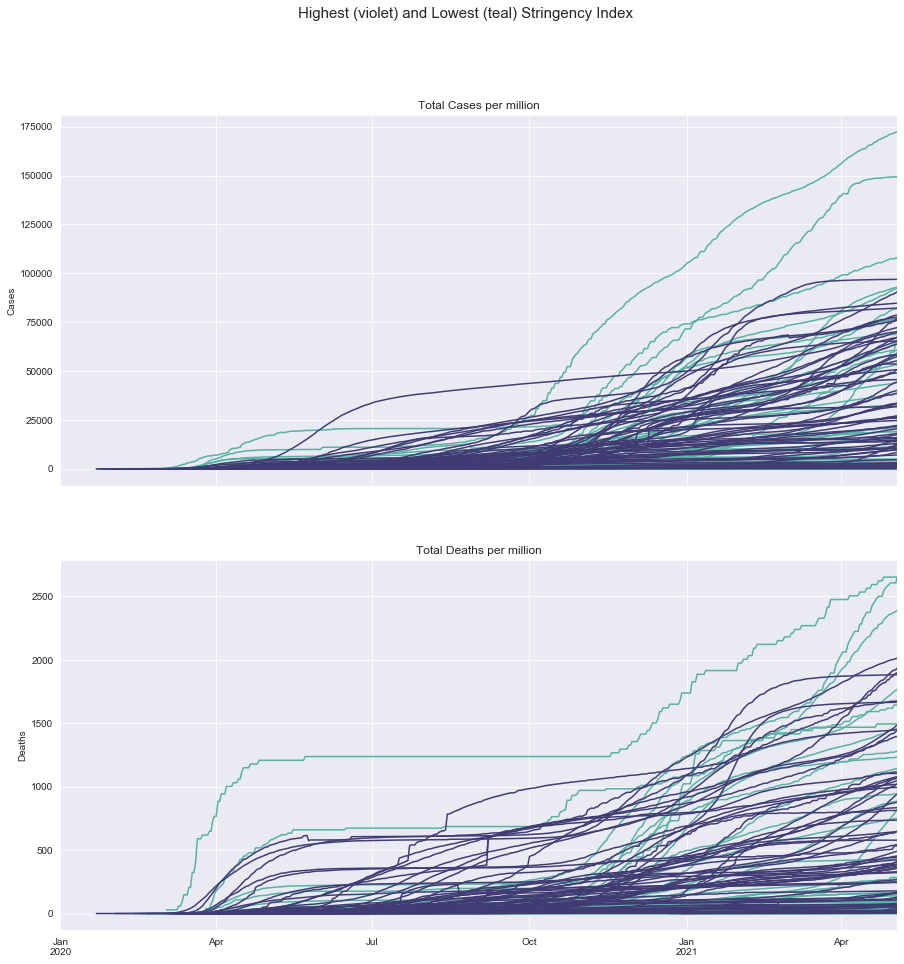

In [91]:
#top/bottom 70 in stringency index
fig, ax = plt.subplots(2,1,figsize=(15,15), sharex=True)

for i in bot5_si:
    for x, y in enumerate([df[df.location==i].total_cases_per_million]):
        y.plot(ax=ax[0], linestyle='-', color='#56b1a3')
for i in top5_si:
    for x, y in enumerate([df[df.location==i].total_cases_per_million]):
        y.plot(ax=ax[0], linestyle='-', color='#403c73')
for i in bot5_si:
    for x, y in enumerate([df[df.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='-', color='#56b1a3')
        #ax[1].annotate(i, xy=(odf.index.max(), odf[odf.location==i].total_deaths_per_million.max()))
for i in top5_si:
    for x, y in enumerate([df[df.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='-', color='#403c73')
        #ax[1].annotate(i, xy=(odf.index.max(), odf[odf.location==i].total_deaths_per_million.max()))
    
ax[0].set(xlabel = '', ylabel='Cases', title='Total Cases per million')
#ax[0].set_title('Total Cases per million',fontsize=20)
#ax[0].legend(top5_si+bot5_si, fontsize='medium')
ax[1].set(xlabel = '', ylabel='Deaths', title='Total Deaths per million')  
#ax[1].set_title('Total Deaths per million',fontsize=20)
fig.suptitle('Highest (violet) and Lowest (teal) Stringency Index', fontsize=15)

(array([ 3.,  4.,  2., 14., 23., 27., 47., 39., 17.,  4.]),
 array([13.66512376, 20.98483387, 28.30454399, 35.6242541 , 42.94396421,
        50.26367432, 57.58338443, 64.90309454, 72.22280466, 79.54251477,
        86.86222488]),
 <a list of 10 Patch objects>)

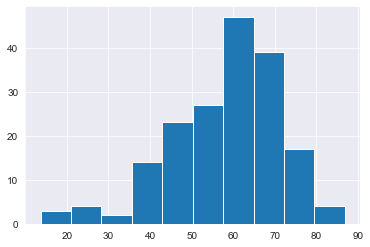

In [93]:
plt.hist(zf.stringency_index)

In [101]:
stringency_up50 = zf[zf.stringency_index > 50]
stringency_down50 = zf[zf.stringency_index < 50]

In [108]:
print(stringency_up50.shape[0], stringency_down50.shape[0])

135 45


Text(0.5, 0.98, 'Highest (violet) and Lowest (teal) Stringency Index')

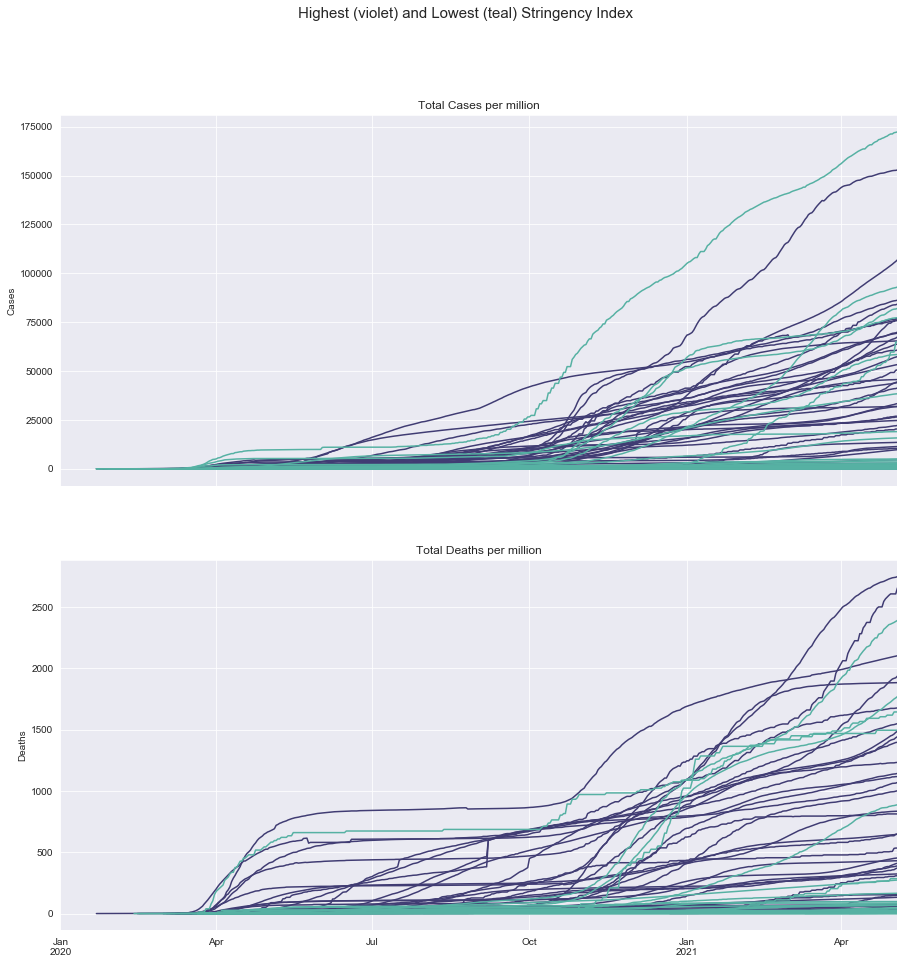

In [109]:
#top/bottom 70 in stringency index
fig, ax = plt.subplots(2,1,figsize=(15,15), sharex=True)

for i in stringency_up50.location.tolist()[:45]:
    for x, y in enumerate([df[df.location==i].total_cases_per_million]):
        y.plot(ax=ax[0], linestyle='-', color='#403c73')
for i in stringency_down50.location.tolist():
    for x, y in enumerate([df[df.location==i].total_cases_per_million]):
        y.plot(ax=ax[0], linestyle='-', color='#56b1a3')
        
for i in stringency_up50.location.tolist()[:45]:
    for x, y in enumerate([df[df.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='-', color='#403c73')
        #ax[1].annotate(i, xy=(odf.index.max(), odf[odf.location==i].total_deaths_per_million.max()))
for i in stringency_down50.location.tolist():
    for x, y in enumerate([df[df.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='-', color='#56b1a3')
        #ax[1].annotate(i, xy=(odf.index.max(), odf[odf.location==i].total_deaths_per_million.max()))

ax[0].set(xlabel = '', ylabel='Cases', title='Total Cases per million')
#ax[0].set_title('Total Cases per million',fontsize=20)
#ax[0].legend(top5_si+bot5_si, fontsize='medium')
ax[1].set(xlabel = '', ylabel='Deaths', title='Total Deaths per million')  
#ax[1].set_title('Total Deaths per million',fontsize=20)
fig.suptitle('Highest (violet) and Lowest (teal) Stringency Index', fontsize=15)

- Stringency index does not seem like a good indicator of COVID19 outcome

In [112]:
#top 10 SI
zf.sort_values(by='stringency_index', ascending=False).head(10)[['location','stringency_index','total_deaths_per_million','total_cases_per_million']]

location  stringency_index  total_deaths_per_million  \
83     Honduras         86.862225                231.893054   
57      Eritrea         86.121945                  2.013985   
210   Venezuela         84.875157                 24.927874   
110       Libya         82.735704                144.042402   
17   Bangladesh         78.723595                 30.356811   
166   Palestine         78.156588                171.734432   
129     Myanmar         77.919418                 24.664108   
40     Colombia         76.921442                573.535719   
12   Azerbaijan         76.742331                138.304136   
159      Panama         75.915938                634.973729   

     total_cases_per_million  
83               8524.072355  
57                293.160712  
210              2575.569626  
110              8907.256644  
17               2037.425714  
166             15745.729939  
129              1098.169473  
40              20212.481033  
12              10119.875247  
159             35320.722261

In [113]:
#bottom 10 SI
zf.sort_values(by='stringency_index', ascending=True).head(10)[['location','stringency_index','total_deaths_per_million','total_cases_per_million']].dropna()

location  stringency_index  total_deaths_per_million  \
141  Nicaragua         13.665124                 18.608428   
13     Burundi         14.989549                  0.162473   
22     Belarus         19.320930                111.387913   
202   Tanzania         22.118478                  0.330445   
212    Vanuatu         24.317086                  3.256000   
201     Taiwan         24.556983                  0.292014   
139      Niger         30.830884                  3.897847   
214      Yemen         33.778303                 18.605803   

     total_cases_per_million  
141               641.616745  
13                 80.654857  
22              13715.091130  
202                 7.759460  
212                 5.660670  
201                23.759360  
139                91.801725  
214                68.584326

## Population Density

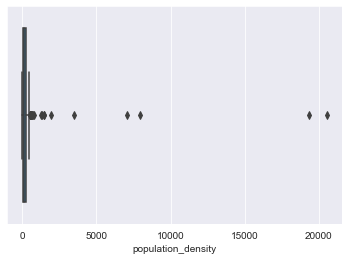

In [137]:
sns.boxplot(odf_totalcases.sort_values(by='population_density').population_density)

In [140]:
odf_totalcases.sort_values(by='population_density',ascending=False).head().population_density

location
Macao        20546.766
Monaco       19347.500
Singapore     7915.731
Hong Kong     7039.714
Gibraltar     3457.100
Name: population_density, dtype: float64

In [110]:
#removing top 5 for better distribution
list_pd = odf_totalcases.sort_values('population_density', ascending=False).head(5).index.tolist()
odf2 = odf_totalcases.copy()
odf2.drop(labels=list_pd, axis=0, inplace=True)

In [117]:
odf2.population_density.describe()

count     194.000000
mean      170.266691
std       263.676519
min         0.137000
25%        35.972500
50%        83.142000
75%       208.157000
max      1935.907000
Name: population_density, dtype: float64

In [115]:
fig = px.choropleth(odf2, locations='iso_code',
                    color='population_density',
                    hover_name=odf2.index, 
                    color_continuous_scale=px.colors.sequential.deep)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

## Hospital beds per thousand
- may act as a mitigator for COVID19 deaths in larger populations

In [84]:
fig = px.choropleth(odf_totalcases, locations='iso_code',
                    color='hospital_beds_per_thousand',
                    hover_name=odf_totalcases.index, 
                    color_continuous_scale=px.colors.sequential.deep)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

In [155]:
hbdf = odf_totalcases.sort_values(by='hospital_beds_per_thousand', ascending=False)[['hospital_beds_per_thousand',
                                                                                     'total_deaths_per_million',
                                                                                     'median_age','population',
                                                                                     'population_density']].dropna()
hbdf.reset_index(inplace=True)
hbdf.head(15)

location  hospital_beds_per_thousand  total_deaths_per_million  \
0         Japan                      13.050                    82.553   
1   South Korea                      12.270                    36.026   
2       Belarus                      11.000                   273.247   
3       Ukraine                       8.800                  1069.677   
4        Russia                       8.050                   751.502   
5       Germany                       8.000                  1001.266   
6      Bulgaria                       7.454                  2390.319   
7       Austria                       7.370                  1142.632   
8       Hungary                       7.020                  2903.104   
9      Mongolia                       7.000                    39.655   
10      Romania                       6.892                  1480.116   
11   Kazakhstan                       6.700                   178.785   
12      Czechia                       6.630                  2747.320   
13       Poland                       6.620                  1800.241   
14    Lithuania                       6.560                  1460.535   

    median_age   population  population_density  
0         48.2  126476458.0             347.778  
1         43.4   51269183.0             527.967  
2         40.3    9449321.0              46.858  
3         41.4   43733759.0              77.390  
4         39.6  145934460.0               8.823  
5         46.6   83783945.0             237.016  
6         44.7    6948445.0              65.180  
7         44.4    9006400.0             106.749  
8         43.4    9660350.0             108.043  
9         28.6    3278292.0               1.980  
10        43.0   19237682.0              85.129  
11        30.6   18776707.0               6.681  
12        43.3   10708982.0             137.176  
13        41.8   37846605.0             124.027  
14        43.5    2722291.0              45.135

- the relationship between dpm and hospital beds is not as strong, however among high density. high median age populations like Japan and Korea, it may mitigate dpm

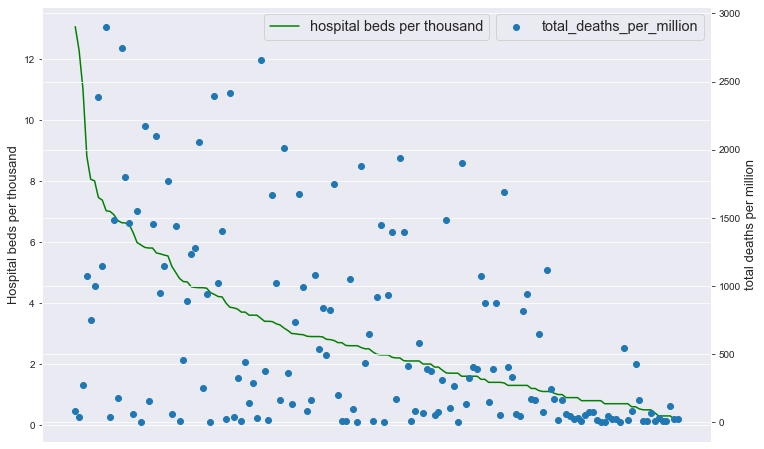

In [157]:
fig, host = plt.subplots(figsize=(12,8))
par1 = host.twinx()

host.set_xlim(auto=True)
host.set_xticks([])
host.set_ylim(auto=True)
par1.set_ylim(auto=True)

host.set_ylabel('Hospital beds per thousand', fontsize=13)
par1.set_ylabel('total deaths per million', fontsize=13)
p1 = host.plot(np.array(hbdf.hospital_beds_per_thousand.values), color='g')
p2 = par1.scatter(x=np.arange(0,len(hbdf)),y=np.array(hbdf.total_deaths_per_million.values))
host.legend(labels=['hospital beds per thousand'], loc='upper center', fontsize='x-large')
par1.legend(labels=['total_deaths_per_million'], loc='upper right', fontsize='x-large')


In [158]:
mdf = hbdf[hbdf.median_age>42]

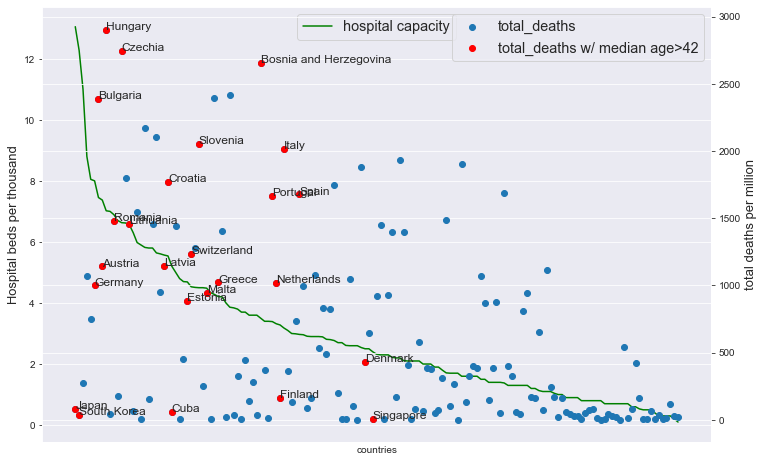

In [159]:
fig, host = plt.subplots(figsize=(12,8))
par1 = host.twinx()

host.set_xlim(auto=True)
host.set_xticks([])
host.set_ylim(auto=True)
par1.set_ylim(auto=True)

host.set_xlabel('countries')
host.set_ylabel('Hospital beds per thousand', fontsize=13)
par1.set_ylabel('total deaths per million', fontsize=13)
p1 = host.plot(np.array(hbdf.hospital_beds_per_thousand.values), color='g')
p2 = par1.scatter(x=np.arange(0,len(hbdf)),y=np.array(hbdf.total_deaths_per_million.values))
p22 = par1.scatter(x=np.array(mdf.index.tolist()), y=np.array(mdf.total_deaths_per_million.values), color='r')
host.legend(labels=['hospital capacity'], loc='upper center', fontsize='x-large')
par1.legend(labels=['total_deaths','total_deaths w/ median age>42'], loc='upper right', fontsize='x-large')

for i in range(mdf.shape[0]):
    plt.annotate(mdf.location.tolist()[i], (mdf.index.tolist()[i], mdf.total_deaths_per_million.tolist()[i]),fontsize=12)

- It may be that beds are most effective after some threshold value. 
    - ie. all countries above 8 beds/thousand have very good COVID19 outcomes, within the same population cohort
- median age and hospital beds per thousand are moderately positively correlated with a pearson coefficient of 0.66

## Female Smokers

In [160]:
fsdf = odf_totalcases.sort_values(by='female_smokers', ascending=False)[['hospital_beds_per_thousand',
                                                                         'total_deaths_per_million',
                                                                         'male_smokers',
                                                                         'female_smokers',
                                                                         'median_age']].dropna()
fsdf.reset_index(inplace=True)

In [161]:
mddf = fsdf[fsdf.median_age>42]

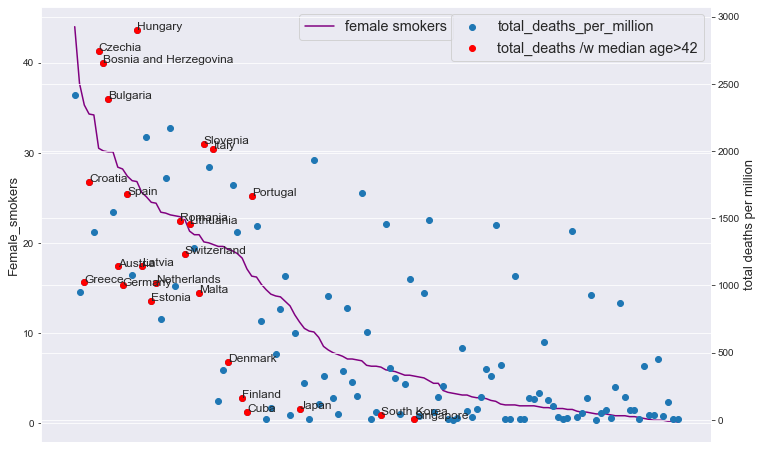

In [162]:
fig, host = plt.subplots(figsize=(12,8))
par1 = host.twinx()

host.set_xlim(auto=True)
host.set_xticks([])
host.set_ylim(auto=True)
par1.set_ylim(auto=True)

host.set_ylabel('Female_smokers', fontsize=13)
par1.set_ylabel('total deaths per million', fontsize=13)
p1 = host.plot(np.array(fsdf.female_smokers.values), color='purple')
p2 = par1.scatter(x=np.arange(0,len(fsdf)),y=np.array(fsdf.total_deaths_per_million.values))
p22 = par1.scatter(x=np.array(mddf.index.tolist()), y=np.array(mddf.total_deaths_per_million.values), color='r')
host.legend(labels=['female smokers'], loc='upper center', fontsize='x-large')
par1.legend(labels=['total_deaths_per_million', 'total_deaths /w median age>42'], loc='upper right', fontsize='x-large')


for i in range(mddf.shape[0]):
    plt.annotate(mddf.location.tolist()[i], (mddf.index.tolist()[i], mddf.total_deaths_per_million.tolist()[i]),fontsize=12)


- female smoker correlation is very strong
- pearson correlation femalesmokers vs total_deaths_per_million = 0.69 which is a strong positive correlation


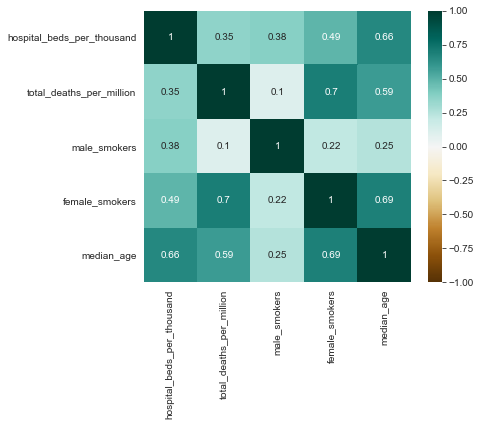

In [163]:
plt.figure(figsize=(6,5))
sns.heatmap(fsdf.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [164]:
msdf = odf_totalcases.sort_values(by='male_smokers', ascending=False)[['hospital_beds_per_thousand',
                                                                       'total_deaths_per_million',
                                                                       'male_smokers',
                                                                       'female_smokers',
                                                                       'gdp_per_capita',
                                                                       'median_age']].dropna()
msdf.reset_index(inplace=True)

In [165]:
mmdf = msdf[msdf.median_age>42]

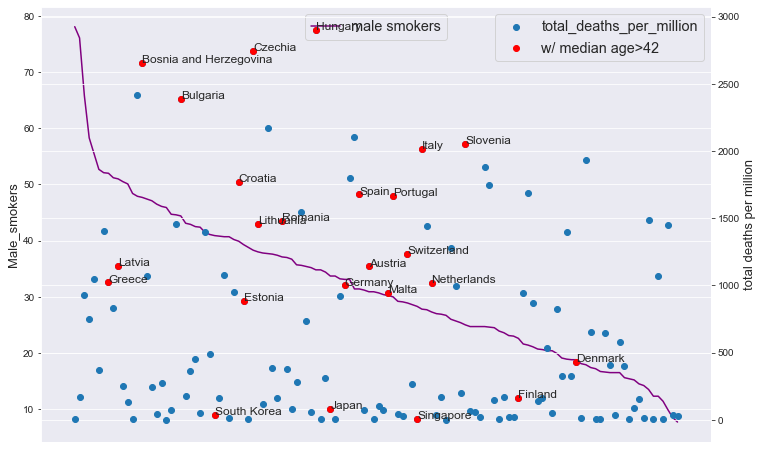

In [166]:
fig, host = plt.subplots(figsize=(12,8))
par1 = host.twinx()

host.set_xlim(auto=True)
host.set_xticks([])
host.set_ylim(auto=True)
par1.set_ylim(auto=True)

host.set_ylabel('Male_smokers', fontsize=13)
par1.set_ylabel('total deaths per million', fontsize=13)
p1 = host.plot(np.array(msdf.male_smokers.values), color='purple')
p2 = par1.scatter(x=np.arange(0,len(msdf)),y=np.array(msdf.total_deaths_per_million.values))
p22 = par1.scatter(x=np.array(mmdf.index.tolist()), y=np.array(mmdf.total_deaths_per_million.values), color='r')
host.legend(labels=['male smokers'], loc='upper center', fontsize='x-large')
par1.legend(labels=['total_deaths_per_million', 'w/ median age>42'], loc='upper right', fontsize='x-large')

for i in range(mmdf.shape[0]):
    plt.annotate(mmdf.location.tolist()[i], (mmdf.index.tolist()[i], mmdf.total_deaths_per_million.tolist()[i]),fontsize=12)

In [86]:
pd.set_option('display.float_format', '{:.2f}'.format)
hbpt = odf_totalcases[odf_totalcases.population.between(100000000,200000000)][['total_deaths_per_million','total_cases_per_million','population','population_density','hospital_beds_per_thousand']].sort_values(by='total_deaths_per_million')

In [87]:
hbpt.sort_values(by='hospital_beds_per_thousand', ascending=False)

total_deaths_per_million  total_cases_per_million   population  \
location                                                                      
Japan                           78.58                  4495.86 126476458.00   
Russia                         729.33                 32265.44 145934460.00   
Egypt                          127.51                  2174.47 102334403.00   
Mexico                        1667.12                 18058.96 128932753.00   
Philippines                    153.16                  9103.06 109581085.00   
Bangladesh                      67.11                  4525.62 164689383.00   
Ethiopia                        30.89                  2194.43 114963583.00   

             population_density  hospital_beds_per_thousand  
location                                                     
Japan                    347.78                       13.05  
Russia                     8.82                        8.05  
Egypt                     98.00                        1.60  
Mexico                    66.44                        1.38  
Philippines              351.87                        1.00  
Bangladesh              1265.04                        0.80  
Ethiopia                 104.96                        0.30

In [167]:
odf_hb7 = odf_totalcases[odf_totalcases.hospital_beds_per_thousand>6]
odf_hb6 = odf_totalcases[odf_totalcases.hospital_beds_per_thousand<6]

top5_hbpt = odf_totalcases.sort_values(by='hospital_beds_per_thousand', ascending=False).head(5).index.tolist()
bot5_hbpt = odf_totalcases.sort_values(by='hospital_beds_per_thousand', ascending=True).head(5).index.tolist()

[Text(0, 0.5, 'Population'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Total deaths per million')]

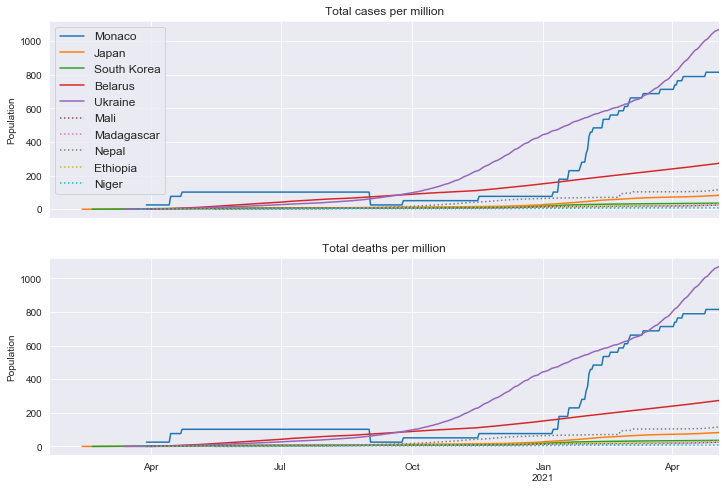

In [168]:
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)

for i in top5_hbpt:
    for x, y in enumerate([df[df.location==i].total_deaths_per_million]):
        y.plot(ax=ax[0], linestyle='-')
for i in bot5_hbpt:
    for x, y in enumerate([df[df.location==i].total_deaths_per_million]):
        y.plot(ax=ax[0], linestyle='dotted')

for i in top5_hbpt:
    for x, y in enumerate([df[df.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='-')
for i in bot5_hbpt:
    for x, y in enumerate([df[df.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='dotted')

ax[0].set(xlabel = '', ylabel='Population', title = 'Total cases per million')  
ax[0].legend(top5_hbpt+bot5_hbpt, fontsize='large')
ax[1].set(xlabel = '', ylabel='Population', title = 'Total deaths per million')  



# Other Correlations

In [170]:
#Removing redundant columns
#some columns are removed due to redundancy
OWIDdf = OWIDdf.drop(columns=['aged_65_older','aged_70_older','iso_code','continent'])

In [171]:
odft=odf_totalcases.copy()
list_ts = [col for col in odft.columns if 'new' in col or 'total' in col or 'people' in col]
odft = odft.drop(columns=['aged_65_older','aged_70_older','iso_code','continent','reproduction_rate','positive_rate','tests_per_case']+list_ts)

In [172]:
odft.describe()

stringency_index    population  population_density  median_age  \
count        180.000000  2.090000e+02          199.000000  186.000000   
mean          82.847444  3.712219e+07          458.987683   30.327419   
std           15.687262  1.428339e+08         2129.379124    9.193067   
min           23.150000  8.090000e+02            0.137000   15.100000   
25%           78.125000  9.880020e+05           36.782500   22.000000   
50%           87.040000  6.948445e+06           87.176000   29.500000   
75%           93.520000  2.637828e+07          213.312000   39.000000   
max          100.000000  1.439324e+09        20546.766000   48.200000   

       gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
count      189.000000       124.000000             187.000000   
mean     19238.101741        13.964516             262.562877   
std      20596.923112        20.309717             121.074399   
min        661.240000         0.100000              79.370000   
25%       4227.630000         0.600000             170.667500   
50%      12236.706000         2.350000             243.964000   
75%      27216.445000        21.675000             332.433000   
max     116935.600000        77.600000             724.417000   

       diabetes_prevalence  female_smokers  male_smokers  \
count           194.000000      144.000000    142.000000   
mean              8.102165       10.667361     32.786620   
std               4.390427       10.715532     13.562219   
min               0.990000        0.100000      7.700000   
25%               5.310000        1.900000     21.850000   
50%               7.155000        6.250000     32.250000   
75%              10.420000       19.150000     41.250000   
max              30.530000       44.000000     78.100000   

       handwashing_facilities  hospital_beds_per_thousand  life_expectancy  \
count               94.000000                  168.000000       206.000000   
mean                50.165947                    3.010583        73.281311   
std                 32.044171                    2.443586         7.615703   
min                  1.188000                    0.100000        53.280000   
25%                 19.728000                    1.300000        67.925000   
50%                 48.753000                    2.398500        74.575000   
75%                 82.035250                    3.895750        78.875000   
max                 98.999000                   13.800000        86.750000   

       human_development_index  
count               186.000000  
mean                  0.722403  
std                   0.150654  
min                   0.394000  
25%                   0.601250  
50%                   0.741000  
75%                   0.835750  
max                   0.957000

In [173]:
odft.corr()

stringency_index  population  population_density  \
stringency_index                    1.000000    0.062582           -0.201241   
population                          0.062582    1.000000           -0.028923   
population_density                 -0.201241   -0.028923            1.000000   
median_age                          0.007544    0.033332            0.149079   
gdp_per_capita                     -0.118204   -0.052241            0.408540   
extreme_poverty                    -0.266618   -0.039960           -0.029067   
cardiovasc_death_rate               0.036437   -0.004428           -0.175534   
diabetes_prevalence                 0.064096    0.018770            0.022763   
female_smokers                     -0.062287   -0.121840           -0.046146   
male_smokers                        0.068994    0.025531            0.001161   
handwashing_facilities              0.425196    0.039389            0.102984   
hospital_beds_per_thousand         -0.067432   -0.037812            0.315750   
life_expectancy                    -0.000750   -0.018612            0.232118   
human_development_index             0.068747   -0.015339            0.180550   

                            median_age  gdp_per_capita  extreme_poverty  \
stringency_index              0.007544       -0.118204        -0.266618   
population                    0.033332       -0.052241        -0.039960   
population_density            0.149079        0.408540        -0.029067   
median_age                    1.000000        0.642209        -0.697290   
gdp_per_capita                0.642209        1.000000        -0.507000   
extreme_poverty              -0.697290       -0.507000         1.000000   
cardiovasc_death_rate        -0.337929       -0.474898         0.189471   
diabetes_prevalence           0.155383        0.165931        -0.401898   
female_smokers                0.668069        0.330631        -0.411692   
male_smokers                  0.190170       -0.093290        -0.192223   
handwashing_facilities        0.785879        0.647415        -0.751043   
hospital_beds_per_thousand    0.662063        0.296886        -0.443556   
life_expectancy               0.845453        0.678731        -0.752270   
human_development_index       0.897659        0.754706        -0.777256   

                            cardiovasc_death_rate  diabetes_prevalence  \
stringency_index                         0.036437             0.064096   
population                              -0.004428             0.018770   
population_density                      -0.175534             0.022763   
median_age                              -0.337929             0.155383   
gdp_per_capita                          -0.474898             0.165931   
extreme_poverty                          0.189471            -0.401898   
cardiovasc_death_rate                    1.000000             0.127022   
diabetes_prevalence                      0.127022             1.000000   
female_smokers                          -0.172090             0.037225   
male_smokers                             0.414919             0.177214   
handwashing_facilities                  -0.039956             0.473175   
hospital_beds_per_thousand               0.015253            -0.054206   
life_expectancy                         -0.466057             0.214595   
human_development_index                 -0.425615             0.212657   

                            female_smokers  male_smokers  \
stringency_index                 -0.062287      0.068994   
population                       -0.121840      0.025531   
population_density               -0.046146      0.001161   
median_age                        0.668069      0.190170   
gdp_per_capita                    0.330631     -0.093290   
extreme_poverty                  -0.411692     -0.192223   
cardiovasc_death_rate            -0.172090      0.414919   
diabetes_prevalence               0.037225      0.177214   
female_smokers                    1.000000      0.

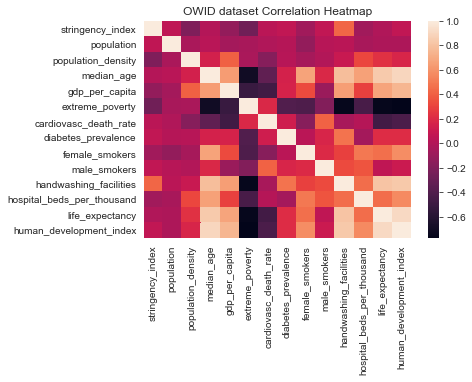

In [174]:
save = sns.heatmap(odft.corr()).set_title('OWID dataset Correlation Heatmap')

#save.figure.savefig('heatmap.png')

Text(0.5, 1, 'Features correlating with total_cases')

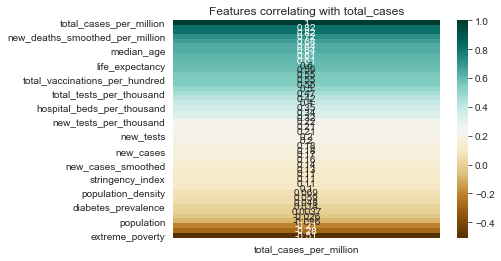

In [175]:
sns.heatmap(odf_totalcases.corr()[['total_cases_per_million']].sort_values(by='total_cases_per_million', ascending=False),
            annot=True, cmap='BrBG').set_title('Features correlating with total_cases')

Text(0.5, 1, 'Features correlating with total_deaths')

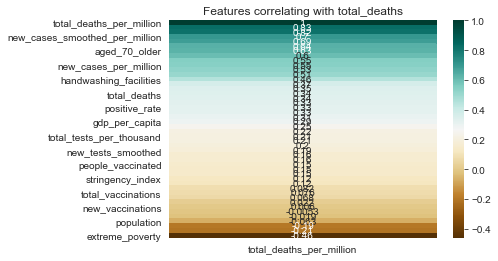

In [176]:
dhmp = sns.heatmap(odf_totalcases.corr()[['total_deaths_per_million']].sort_values(by='total_deaths_per_million', ascending=False), annot=True, cmap='BrBG')
dhmp.set_title('Features correlating with total_deaths')

Some of the target variables to consider: reproduction_rate, total_cases_per_million, total_deaths_per_million.
Normally we would also consider crude mortality rate or case-fatality rate as well. However, confirmed cases is often underreported AND undertested and as such may be harder to evaluate accurately. It is important to consider that the data being robust and accurate relies heavily on the nation's testing capacity. 

Remember that the reproduction rate (R) describes the trajectory of the virus. A value of R = 1 means the amount of new infections and new recoveries are equal; meaning the virus numbers will stagnate. A value of 6.74 means the number of infected is sharply increasing and may lead in a big spike of infections and deaths, depending on government mitigation strategy.

In [847]:
print(OWIDdf.reproduction_rate.max())
odf[odf.reproduction_rate==OWIDdf.reproduction_rate.max()]

5.71


iso_code continent     location  total_cases  new_cases  \
date                                                                 
2020-02-21      KOR      Asia  South Korea        204.0      100.0   

            new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
date                                                                            
2020-02-21              25.143           2.0         1.0                0.286   

            total_cases_per_million  ...  gdp_per_capita  extreme_poverty  \
date                                 ...                                    
2020-02-21                    3.979  ...       35938.374              0.2   

            cardiovasc_death_rate  diabetes_prevalence  female_smokers  \
date                                                                     
2020-02-21                 85.998                  6.8             6.2   

            male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
date                                                                           
2020-02-21          40.9                     NaN                       12.27   

            life_expectancy  human_development_index  
date                                                  
2020-02-21            83.03                    0.916  

[1 rows x 50 columns]

# Bubble Visualizations

In [198]:
odf1 = df.groupby(df['location']).agg(['max'])
odf1.columns = odf1.columns.droplevel(1)
odf1.reset_index(level=0, inplace=True)

In [199]:
odf1 = odf1[odf1.population.notna()]

odf1 = odf1[odf1.total_cases.notna()]

odf1 = odf1[odf1.population_density.notna()]

odf1 = odf1[odf1.human_development_index.notna()]

odf1 = odf1[odf1.gdp_per_capita.notna()]

odf1 = odf1[odf1.total_deaths_per_million.notna()]

odf1 = odf1[odf1.life_expectancy.notna()]

In [200]:
odf1 = odf1[-odf1.location.isin(['World','European Union','North America','South America','Asia','Africa','Europe','Oceania'])]

In [201]:
odfpx = odf1.sort_values(by='population_density', ascending=False).head(10)

In [181]:
px.scatter(odf1, x='life_expectancy',y='human_development_index', size='gdp_per_capita',
           color ='continent', hover_name='location',
           title='HDI vs Life_expectancy vs gdp_per_capita')

In [182]:
px.scatter(odf1, x='life_expectancy',y='human_development_index', size='total_deaths_per_million',
           color ='continent', hover_name='location',
           title='HDI vs Life_expectancy vs dpm')

In [183]:
px.scatter(odf1, x='life_expectancy',y='human_development_index', size='median_age',
           color ='continent', hover_name='location',
           title='HDI vs Life_expectancy vs dpm')

- Countries with lower life expectancy, HDI and GDP tend to fare better against COVID deaths
- Possible reason: GDP, HDI lead to better life expectancy, which leads to higher median age
    - effectively a larger proportion of population is at risk

In [184]:
px.scatter(odf1, x='life_expectancy',y='human_development_index', size='diabetes_prevalence',
           color ='continent', hover_name='location',
           title='HDI vs Life_expectancy vs diabetes')

In [185]:
px.scatter(odf1, x='life_expectancy',y='human_development_index', size='cardiovasc_death_rate',
           color ='continent', hover_name='location',
           title='HDI vs Life_expectancy vs cardiovasc')

In [186]:

px.scatter(odf1, x='cardiovasc_death_rate',y='diabetes_prevalence', size='total_deaths_per_million',
           color ='continent', hover_name='location',
           title='cardiovasc vs diabetes vs total_deaths_per_million')

In [187]:
px.scatter(odf1, x='male_smokers',y='female_smokers', size='total_deaths_per_million',
           color ='continent', hover_name='location',
           title='msmoke vs fsmoke vs total_deaths_per_million')

- very strong correlation between female smokers and total dpm

In [202]:
odf1 = odf1[odf1.median_age.notna()]

In [203]:
odf1.sort_values(by='population_density', ascending=False)[['location','population_density']]

location  population_density
177   Singapore            7915.731
16      Bahrain            1935.907
122    Maldives            1454.433
124       Malta            1454.037
17   Bangladesh            1265.036
..          ...                 ...
189    Suriname               3.612
90      Iceland               3.404
12    Australia               3.202
138     Namibia               3.078
132    Mongolia               1.980

[172 rows x 2 columns]

In [224]:
odf1 = odf1[odf1.location!='China']
odf1 = odf1[odf1.location!='India']

In [225]:
px.scatter(odf1, x='population',y='total_deaths_per_million', size='population_density',
           color ='continent', hover_name='location',
           title='population density')

In [204]:
odfdt_vis = odf1[odf1['handwashing_facilities'].notna()]

In [205]:
px.scatter(odfdt_vis,x='total_deaths_per_million',y='handwashing_facilities',
           color='continent', hover_data=['location'],
           title='Handwashing facilities and crude mortality')

The data shows that having more handwashing facilities doesn't necessarily indicate better COVID19 outcomes

In [206]:
px.scatter(odfdt_vis,x='total_deaths_per_million',y='median_age',
           color='location', hover_data=['location'],
           title='median age and dpm')

- Countries with higher median age are typically hit harder

# Data Mining experimenting

## Random Forest Regressor
- Feature importances help develop a feature profile for the strongest affectors of the pandemic
- RF does not need data normalization as it is a tree-based algorithm; there is no distance function

In [57]:
#removing time-series-attributes
list_nocol = [col for col in df.columns if 'new' in col or 'per' in col or 'people' in col or 'aged' in col or 'units' in col]

## RF Importances 

In [116]:
def RFimportances(y, X):
    #Train test split
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
    
    #Imputing median in NA
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp = imp.fit(train_X)
    train_X = imp.transform(train_X)

    valimp = SimpleImputer(missing_values=np.nan, strategy='median')
    valimp = valimp.fit(val_X)
    val_X = valimp.transform(val_X)

    val_y = val_y.fillna(val_y.median())
    train_y = train_y.fillna(train_y.median())
    
    #Model fitting
    clf = RandomForestRegressor(n_estimators=100, bootstrap = True, random_state = 1)
    clf = clf.fit(train_X, train_y)
    
    #Model evaluation
    print("Model Evaluation:")
    print('R^2 training set: {:.2f} \nR^2 val set: {:.2f}'.format(clf.score(train_X, train_y),clf.score(val_X, val_y)))
    val_pred = clf.predict(val_X)
    val_mae = mean_absolute_error(val_pred, val_y)
    print("validation MAE: {:,.0f}\n".format(val_mae))

    
    #Feature Importances
    print("Feature Importances")
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]

    for f in range (train_X.shape[1]):
        featurelist = []
        featurelist.append(X.columns[indices[f]])
        print(f"{X.columns.get_loc(X.columns[indices[f]])}\t"
              f"{X.columns[indices[f]]} "
              f"{importances[indices[f]]:.4f}")

    plt.figure(figsize=(12,8))
    plt.title("Feature importances")
    plt.bar(d, importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(train_X.shape[1]), indices)
    plt.xlim([-1, train_X.shape[1]])
    plt.show()
    
    #Permutation importances
    print('Permutation Importances')
    a,b,c = [],[],[]
    r = permutation_importance(clf, val_X, val_y)
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            a.append(r.importances_mean[i])
            b.append(str(i+1))
            c.append(r.importances_std[i])
            print(f"{i+1} \t"
                  f"{X.columns[i]:<8} \t"
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

    plt.figure(figsize=(12,8))
    plt.title("Permutation importances")
    plt.bar(b, a, yerr=c, color="r", align="center")
    plt.xticks(b)
    plt.show()

## Target variable: total_deaths
- total deaths is a good target variable

In [112]:
y = df.total_deaths
X = df[df.columns.difference(list_nocol+['iso_code','location','continent','crude_mortality','total_deaths','positive_rate','population','total_cases','tests_units'])] 

Model Evaluation:
R^2 training set: 0.85 
R^2 val set: 0.74
validation MAE: 5,707

Feature Importances
13	total_vaccinations 0.6377
6	life_expectancy 0.1074
9	population_density 0.0929
12	total_tests 0.0576
11	stringency_index 0.0253
0	cardiovasc_death_rate 0.0213
2	extreme_poverty 0.0181
1	diabetes_prevalence 0.0108
5	human_development_index 0.0090
3	female_smokers 0.0069
7	male_smokers 0.0053
10	reproduction_rate 0.0049
8	median_age 0.0025
4	handwashing_facilities 0.0007


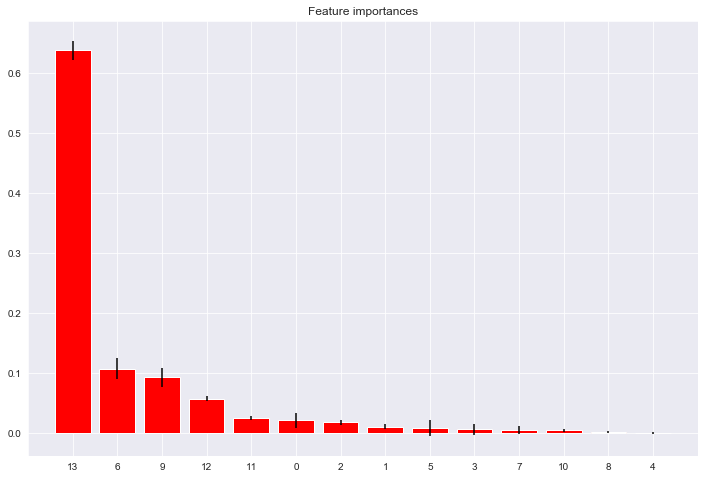

Permutation Importances
14 	total_vaccinations 	0.936 +/- 0.028
10 	population_density 	0.209 +/- 0.018
7 	life_expectancy 	0.181 +/- 0.008
13 	total_tests 	0.118 +/- 0.003
3 	extreme_poverty 	0.067 +/- 0.004
12 	stringency_index 	0.044 +/- 0.003
1 	cardiovasc_death_rate 	0.024 +/- 0.004
2 	diabetes_prevalence 	0.019 +/- 0.001
9 	median_age 	0.012 +/- 0.001
11 	reproduction_rate 	0.010 +/- 0.001
6 	human_development_index 	0.005 +/- 0.002
4 	female_smokers 	0.004 +/- 0.000
8 	male_smokers 	0.001 +/- 0.001
5 	handwashing_facilities 	0.001 +/- 0.000


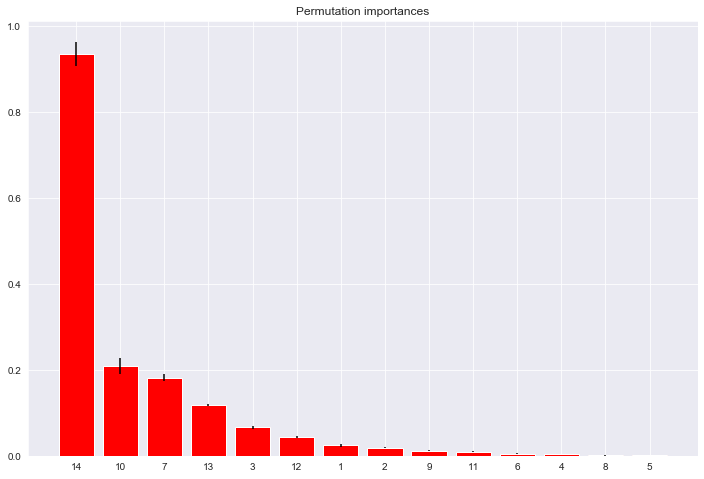

In [117]:
RFimportances(y, X)

## Target variable: total_deaths_per_million
- may be better target than simply total_deaths
- normalized for population differences
- population and total_deaths must be removed to prevent multicollinearity

In [128]:
y = df.total_deaths_per_million
X = df[df.columns.difference(list_nocol+['iso_code','location','continent','crude_mortality','total_deaths','positive_rate','population','total_cases','tests_units'])] 

Model Evaluation:
R^2 training set: 0.98 
R^2 val set: -3.31
validation MAE: 468

Feature Importances
13	total_vaccinations 0.2724
3	female_smokers 0.1199
12	total_tests 0.1049
11	stringency_index 0.0928
5	human_development_index 0.0757
6	life_expectancy 0.0621
9	population_density 0.0559
2	extreme_poverty 0.0505
10	reproduction_rate 0.0455
7	male_smokers 0.0398
0	cardiovasc_death_rate 0.0299
1	diabetes_prevalence 0.0240
8	median_age 0.0173
4	handwashing_facilities 0.0092


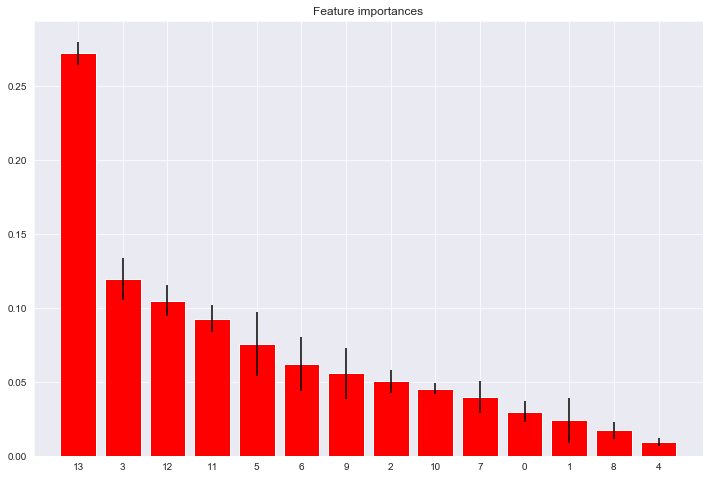

Permutation Importances
4 	female_smokers 	0.506 +/- 0.037
6 	human_development_index 	0.291 +/- 0.003
14 	total_vaccinations 	0.072 +/- 0.013
13 	total_tests 	0.029 +/- 0.000
7 	life_expectancy 	0.025 +/- 0.002
11 	reproduction_rate 	0.009 +/- 0.003


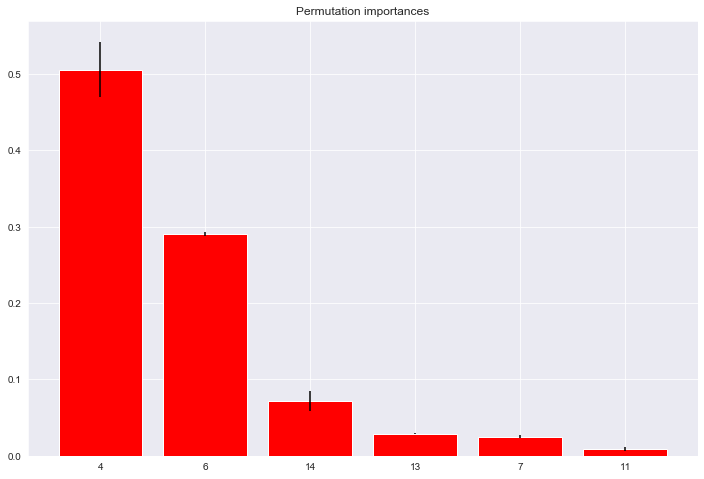

In [129]:
RFimportances(y, X)
#weak model

## Target variable: total_cases
- insight how the virus spread

In [130]:
y = df.total_cases
X = df[df.columns.difference(list_nocol+['iso_code','location','continent','crude_mortality','total_deaths','positive_rate','population','total_cases','tests_units'])] 

Model Evaluation:
R^2 training set: 0.89 
R^2 val set: 0.79
validation MAE: 192,535

Feature Importances
13	total_vaccinations 0.6767
9	population_density 0.1032
12	total_tests 0.0827
6	life_expectancy 0.0594
5	human_development_index 0.0252
0	cardiovasc_death_rate 0.0133
11	stringency_index 0.0128
7	male_smokers 0.0112
2	extreme_poverty 0.0073
10	reproduction_rate 0.0026
3	female_smokers 0.0019
8	median_age 0.0018
1	diabetes_prevalence 0.0017
4	handwashing_facilities 0.0003


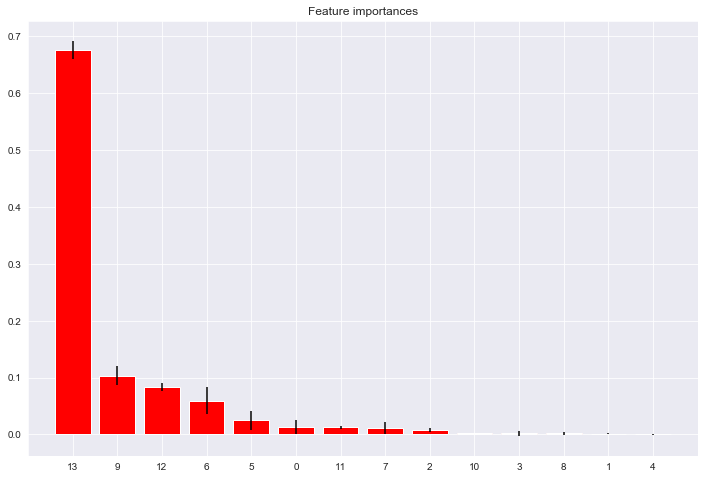

Permutation Importances
14 	total_vaccinations 	1.109 +/- 0.027
10 	population_density 	0.307 +/- 0.021
13 	total_tests 	0.232 +/- 0.004
7 	life_expectancy 	0.076 +/- 0.002
3 	extreme_poverty 	0.074 +/- 0.002
6 	human_development_index 	0.065 +/- 0.002
12 	stringency_index 	0.020 +/- 0.001
1 	cardiovasc_death_rate 	0.011 +/- 0.002
8 	male_smokers 	0.006 +/- 0.002
11 	reproduction_rate 	0.005 +/- 0.001
9 	median_age 	0.002 +/- 0.000
2 	diabetes_prevalence 	0.001 +/- 0.000
5 	handwashing_facilities 	0.000 +/- 0.000


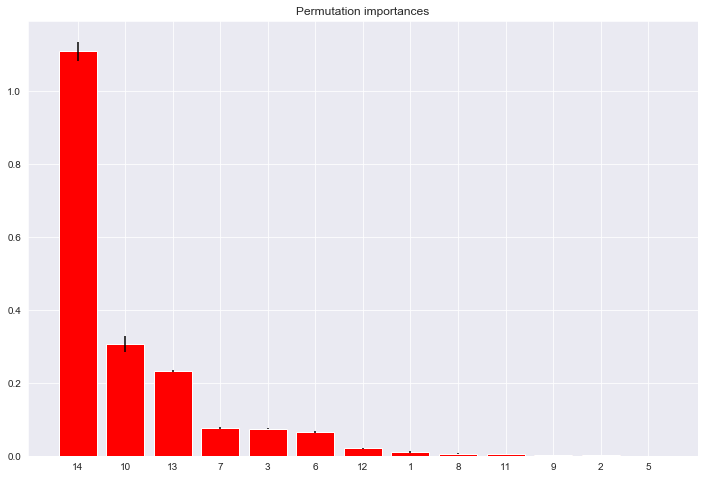

In [131]:
RFimportances(y, X)

- Vaccinations, population density, testing, and female smokers seem to be the strongest features based on these permutation importances for COVID19 outcomes.
- Testing is a special case; it doesn't necessarily affect COVID19 spread but affects our view of the data. 
- Each region has different testing regimes and capacity; therefore confirmed cases may not reflect the true number of COVID19 cases. Higher testing capacity will also mean more total cases.

# Forecasting

# ARIMA forecasting model
- arima will be used to forecast deaths and cases for the next 30 days in Canada
- pdq parameters will be tuned using a wrapper method 
    - source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7409837/
    - this method tests combinations of pdq values for the lowest AIC

In [228]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

## ARIMA preprocessing

In [227]:
df.describe()

total_cases      new_cases  new_cases_smoothed  total_deaths  \
count  8.339900e+04   83397.000000        82402.000000  7.370300e+04   
mean   5.794680e+05    4045.452378         4043.805032  1.615520e+04   
std    3.006254e+06   20690.445302        20214.508790  7.081724e+04   
min    1.000000e+00  -74347.000000        -6223.000000  1.000000e+00   
25%    9.355000e+02       2.000000            6.857000  4.500000e+01   
50%    1.041800e+04      68.000000           84.143000  3.130000e+02   
75%    1.090960e+05     745.000000          776.393250  2.984000e+03   
max    4.524420e+07  518375.000000       494924.714000  1.025369e+06   

         new_deaths  new_deaths_smoothed  total_cases_per_million  \
count  73861.000000         82402.000000             82946.000000   
mean      96.698434            85.795962             10287.550455   
std      424.261605           384.890159             19678.614687   
min    -1918.000000          -232.143000                 0.001000   
25%        0.000000             0.000000               204.410000   
50%        2.000000             1.143000              1395.313000   
75%       17.000000            13.143000             10079.628500   
max     7554.000000          5608.286000            172341.940000   

       new_cases_per_million  new_cases_smoothed_per_million  \
count           82944.000000                    81954.000000   
mean               74.744025                       74.878512   
std               176.908850                      149.649329   
min             -2153.437000                     -276.825000   
25%                 0.183000                        1.154000   
50%                 7.542000                       10.009500   
75%                68.343750                       76.445000   
max              8652.658000                     2648.773000   

       total_deaths_per_million  ...  gdp_per_capita  extreme_poverty  \
count              73263.000000  ...    77319.000000     52480.000000   
mean                 229.113244  ...    19159.036552        13.384221   
std                  401.981273  ...    19884.892070        20.031419   
min                    0.001000  ...      661.240000         0.100000   
25%                    6.857000  ...     4466.507000         0.500000   
50%                   39.647000  ...    12294.876000         2.000000   
75%                  244.494500  ...    27216.445000        21.200000   
max                 2903.104000  ...   116935.600000        77.600000   

       cardiovasc_death_rate  diabetes_prevalence  female_smokers  \
count           77909.000000         79071.000000    60931.000000   
mean              257.984353             7.817799       10.550631   
std               119.126998             3.990647       10.436434   
min                79.370000             0.990000        0.100000   
25%               167.295000             5.290000        1.900000   
50%               243.811000             7.110000        6.200000   
75%               329.635000            10.080000       19.300000   
max               724.417000            30.530000       44.000000   

       male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
count  60026.000000            38918.000000                71046.000000   
mean      32.641809               50.798883                    3.031442   
std       13.527148               31.937483                    2.471305   
min        7.700000                1.188000                    0.100000   
25%       21.400000               19.351000                    1.300000   
50%       31.400000               49.542000                    2.397000   
75%       41.100000               83.241000                    4.000000   
max       78.100000               98.999000                   13.800000   

       life_expectancy  human_development_index  
count     81146.000000             77791.000000  
mean         73.167243                 0.727017  
std           7.571119                 0.150508  
min 

In [229]:
#rolling average for each variable
def cra(country,case='total_cases'):
    ts=df.loc[(df['location']==country)]  
    ts=ts[[case]]
    a=len(ts.loc[(ts[case]>=10)])
    ts=ts[-a:]
    ts.astype('int64')
    return (ts.rolling(window=7,center=False).mean().dropna())


def crplot(country, case='total_cases'):
    ts=df.loc[(df['location']==country)]  
    ts=ts[[case]]
    a=len(ts.loc[(ts[case]>=10)])
    ts=ts[-a:]
    ts.astype('int64')
    
    plt.figure(figsize=(16,6))
    plt.plot(ts[case])
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.legend(['Cases', 'Rolling Mean'])
    plt.title(f'{country}: Rolling mean and cases for {case}')

## Stationarity testing

In [230]:
c1 = cra('Canada',case='total_cases')

In [231]:
def stationarity(ts):
    print('Augmented Dickey-Fuller test: Canada\'s total_cases')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations'])
    print(results)

stationarity(c1.total_cases.values)

Augmented Dickey-Fuller test: Canada's total_cases
Test Statistic              1.557522
p-value                     0.997724
Lags Used                  16.000000
Number of Observations    413.000000
dtype: float64


The p-value tells us the likelihood of stationarity. Because this p-value is over the alpha limit, we cannot reject the null hypothesis that the data contains a unit root, and the data may be non-stationary. 
ARIMA is a good model in this case, with differencing.

Augmented Dickey-Fuller test: Canada's total_cases
Test Statistic              1.557522
p-value                     0.997724
Lags Used                  16.000000
Number of Observations    413.000000
dtype: float64


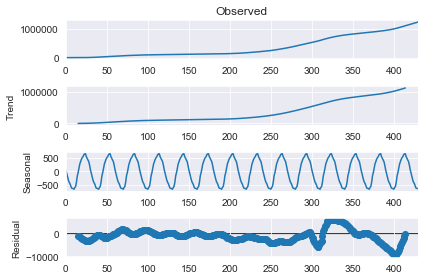

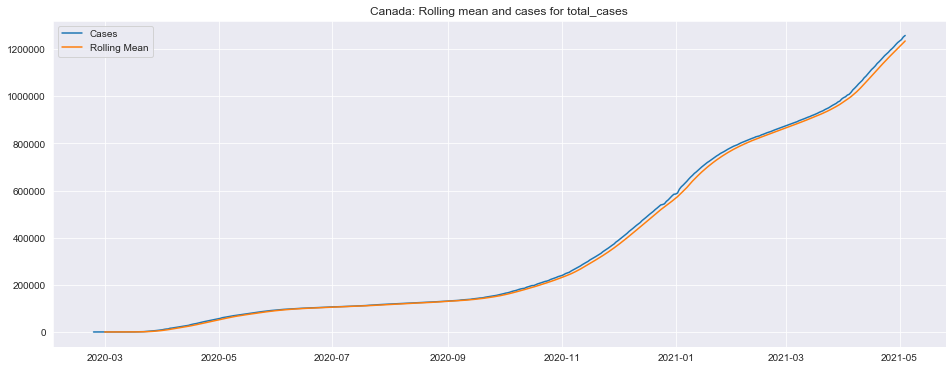

In [232]:
stationarity(cra('Canada').total_cases.values)
fig = sm.tsa.seasonal_decompose(cra('Canada').values, period = 30).plot()
crplot('Canada')

Augmented Dickey-Fuller test: Canada's total_cases
Test Statistic             1.70
p-value                    1.00
Lags Used                 16.00
Number of Observations   395.00
dtype: float64


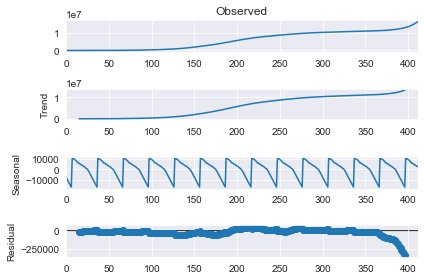

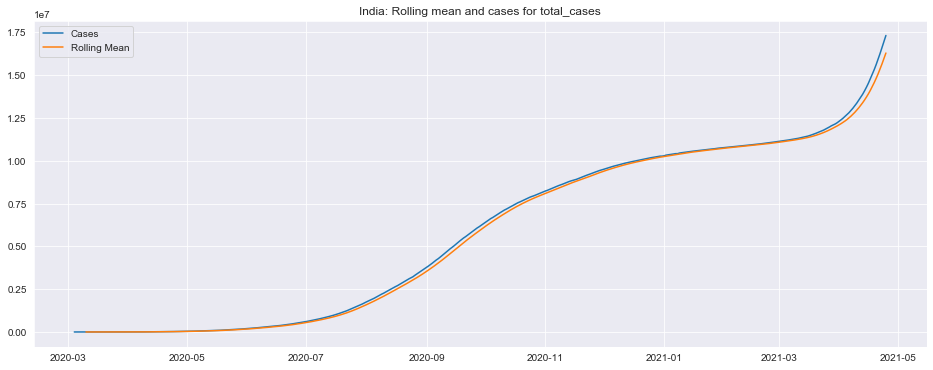

In [100]:
#other countries for curiosity
stationarity(cra('India').total_cases.values)
fig = sm.tsa.seasonal_decompose(cra('India').values, period = 30).plot()
crplot('India')

Augmented Dickey-Fuller test: Canada's total_cases
Test Statistic            -0.61
p-value                    0.87
Lags Used                 18.00
Number of Observations   435.00
dtype: float64


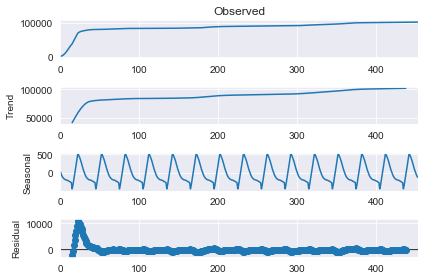

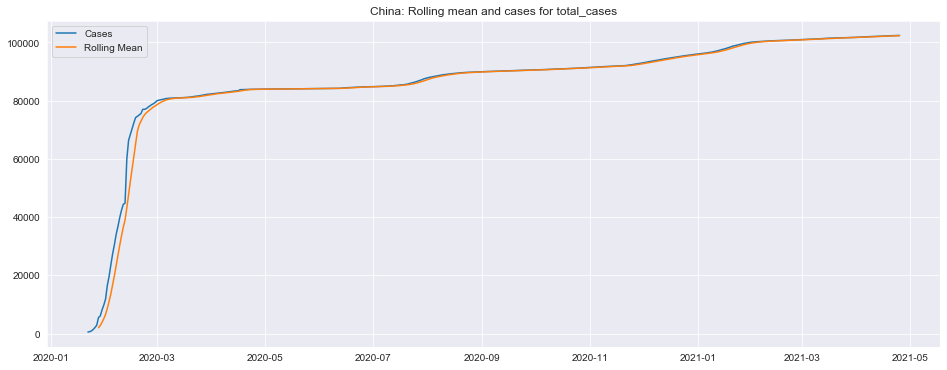

In [101]:
stationarity(cra('China').total_cases.values)
fig = sm.tsa.seasonal_decompose(cra('China').values, period = 30).plot()
crplot('China')

## ACF and PACF

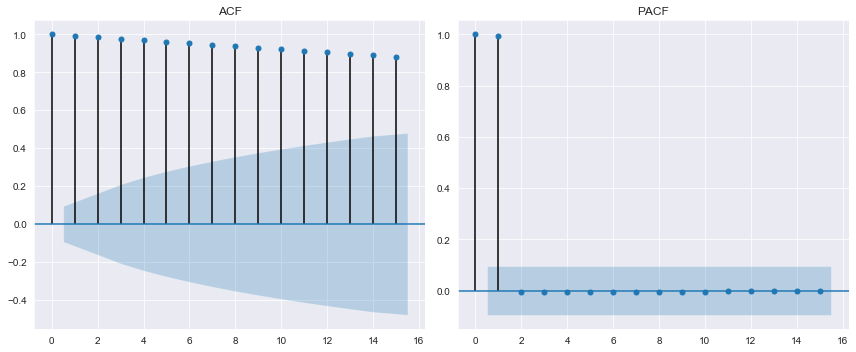

In [233]:
def autocorr(ts):
    plt.figure(figsize=(12,5))
    layout = (1, 2)
    
    ax_acf= plt.subplot2grid(layout, (0, 0))
    ax_pacf = plt.subplot2grid(layout, (0, 1))
    
    plot_acf(ts, lags=15, title='ACF', ax=ax_acf)
    plot_pacf(ts, lags=15, title='PACF', ax=ax_pacf)
    plt.tight_layout()
    
autocorr(cra('Canada'))
#ACF and PACF for Canada;

- normally ACF helps determine q and PACF determines p, but I will be using a function to optimize AIC to deliver best results

## ARIMA Modeling
- predictions using the model will be 30 days from today

In [234]:
from math import sqrt

In [250]:
#Train-test splitting on time series data
def split(ts):
    date = int(len(ts) * 0.85)
    train = ts[:date]
    test = ts[date:]
    return(train, test)

#(p,D,q) hyperparameter evaluation based on AIC
def arima(ts,test):
    p = d = q = range(0,6)
    x = 100000
    pdq = list(itertools.product(p,d,q))
    
    for combo in pdq:
        try:
            model = ARIMA(ts, order=combo)
            result = model.fit()
            if (result.aic <= x):
                x = result.aic
                param = combo
        except:
            continue
    return param

def rmse(y1, y_pred):
    y1, y_pred = np.array(y1), np.array(y_pred)
    return sqrt(mean_squared_error(y1, y_pred))

def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def ARIMAmodel(country, case):
    c1 = cra(country, case)
    series = c1[case].values
    train,test=split(series)
    pdq = arima(train,test)

    #Modeling
    model = ARIMA(train, order=pdq)
    result = model.fit()
    return result


In [244]:
def ARIMAfigs(result, case, days = 30):
    
    c = cra('Canada',case=case)
    train, test = split(c[case].values)
    z, y = np.hstack(train), np.hstack(test)
    length = len(z) + len(y)
    zy = pd.DataFrame({'x':range(len(z)-10,len(z)+len(y)-10), 'y':y})
    zy.set_index('x', inplace=True)
    
    plt.figure(figsize=(15,10))
    layout=(1,1)

    #days forecasted
    forecast = plt.subplot2grid(layout, (0,0))
    plt.setp(forecast, 
             xticks=[0,length/5,(length/5)*2,(length/5)*3,(length/5)*4,length-10,length+days],
             xticklabels=[str(c.index.min())[:10],'','','','',str(c.index.max())[:10],''])
    
    #Predict the test set + next 30 days
    result.plot_predict(start=10, end=length+days, ax=forecast)
    forecast.legend(fontsize='xx-large', loc='upper left')
    forecast.tick_params(axis='x', labelsize=15)
    forecast.tick_params(axis='y', labelsize=13)
    forecast.set_ylabel(f'COVID19 {case}', fontsize=15)
    forecast.set_title(f'ARIMA Model Predictions for COVID19 {case} in Canada', fontsize=20 )
    pred=result.forecast(steps=len(test))[0]
    
    #Model Error plots
    fig, ax = plt.subplots(1, 2, figsize=(16,4))

    ax[0].plot(pred, c='#1f77b4', label = 'Predicted')
    ax[0].plot(test, c='r', label = 'Actual')
    forecast.plot(zy, c='r', label = 'Actual')
    ax[1].plot(pred-y, c='purple', label = 'Residuals', marker='*')
    plt.setp(ax[0], xticks=[0, len(pred)], xticklabels=[str(c.index[len(z)+1])[:10], str(c.index.max())[:10]])
    ax[1].tick_params(axis='x', labelsize=13)
    fig.suptitle('ARIMA Model error', fontsize=20 )
    
    ax[1].annotate(f"RMSE:{rmse(test,pred):.3f}\nMAPE:{mape(test,pred):.3f}\n",
                   xy=(0.05, 0.55), fontsize=15,
                   xycoords = 'axes fraction', xytext=(0.05,0.55))
    
    forecast.legend(['Forecast', 'Actual', 'Actual(test set)', '95% CI'], loc = 'upper left', fontsize='xx-large')
    ax[0].legend(loc='upper left', fontsize='x-large')
    ax[1].legend(loc='upper left', fontsize='x-large')
    
    #creating the predictions list
    datelist = pd.date_range(c.index.max(), periods=days).tolist()
    dates = []
    for date in datelist:
        dates.append(str(date)[:10])
    oospred = result.forecast(steps=len(test)+days)[0]
    fpreds = pd.DataFrame({'Date':dates,'OOS Preds':oospred[len(test):]})
    
    print(result.summary(), '\n')
    print('Evaluation metrics:\n'
          f"RMSE:{rmse(test,pred):.3f}\n"
          f"MAPE:{mape(test,pred):.3f}\n")
    print(f'{days} day predictions\n', fpreds)

In [236]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, HessianInversionWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', HessianInversionWarning)

In [239]:
model_td = ARIMAmodel(country='Canada', case='total_deaths')
model_tc = ARIMAmodel(country='Canada', case='total_cases')

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  363
Model:                 ARIMA(5, 2, 5)   Log Likelihood               -2268.434
Method:                       css-mle   S.D. of innovations            123.239
Date:                Wed, 05 May 2021   AIC                           4560.869
Time:                        04:34:57   BIC                           4607.602
Sample:                             2   HQIC                          4579.445
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0657     15.957      0.505      0.613     -23.210      39.342
ar.L1.D2.y     0.3065      0.096      3.205      0.001       0.119       0.494
ar.L2.D2.y     0.2830      0.056      5.093      0.0

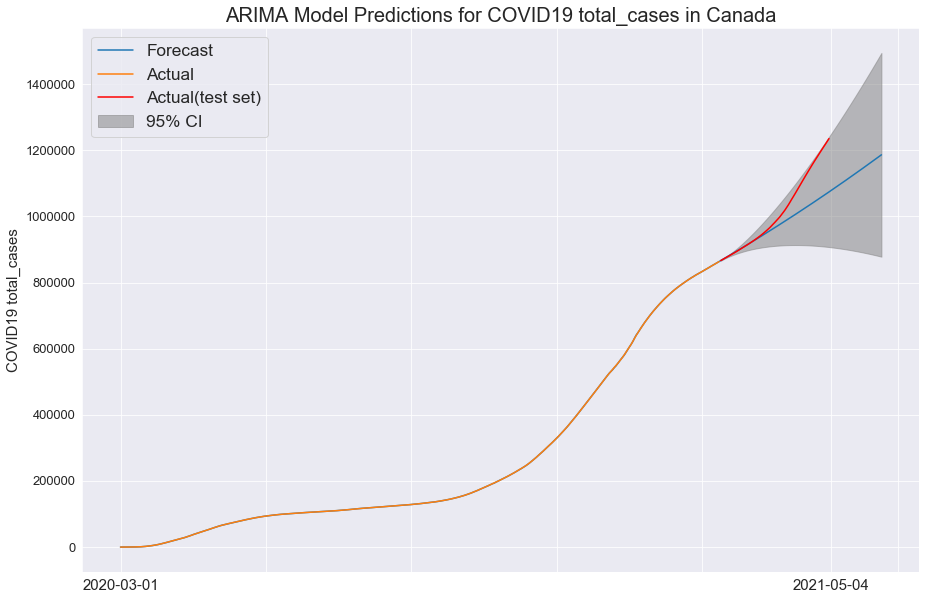

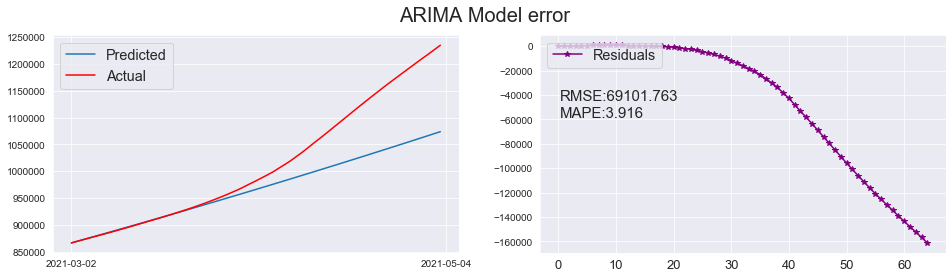

In [251]:
ARIMAfigs(model_tc, case='total_cases')

-As of May 1: this arima model fails because the train data ends before the 3rd wave spike in cases

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  343
Model:                 ARIMA(5, 2, 3)   Log Likelihood                -884.379
Method:                       css-mle   S.D. of innovations              3.154
Date:                Wed, 05 May 2021   AIC                           1788.758
Time:                        04:33:30   BIC                           1827.135
Sample:                             2   HQIC                          1804.045
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1530      0.865      0.177      0.860      -1.543       1.849
ar.L1.D2.y     0.3516      0.086      4.065      0.000       0.182       0.521
ar.L2.D2.y    -0.3485      0.061     -5.733      0.0

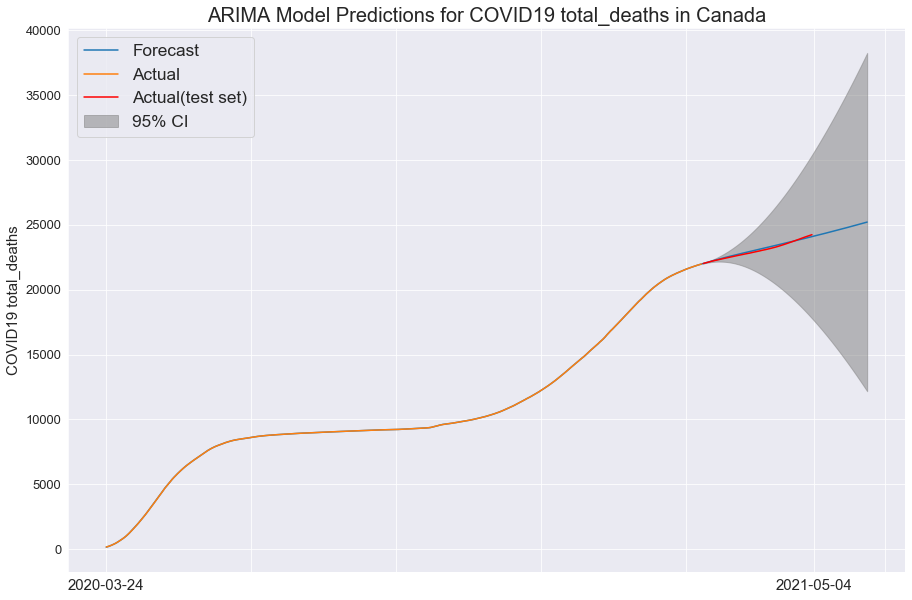

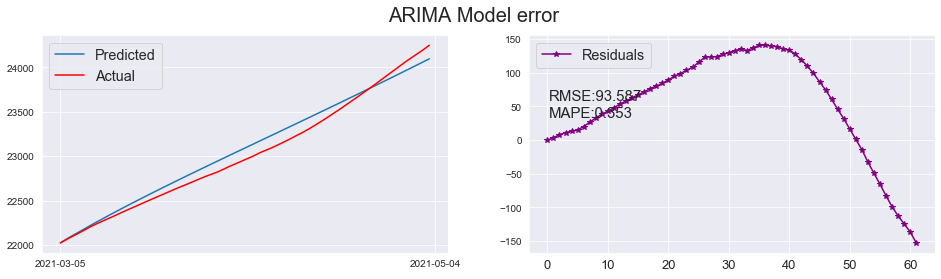

In [246]:
ARIMAfigs(model_td, case='total_deaths')

- The ARIMA(5,2,5) for cases and ARIMA(5,2,4) for deaths were relatively robust for the first 30 days and predicted the trajectory of COVID19 with moderate succuss
- ARIMA as a simple model is a robust forecast in some areas but does not account for randomness or erratic behavior as observed with COVID waves and spikes

# Summary
Analysis of pandemic data is crucial for preparation of the next pandemic event.
- Strongest demographic factors for COVID19 outcomes are median age, female smoker population, population density. 
- Key mitigators may be hospital beds per thousand, and total vaccinations.
- It is important to note that total testing's high correlation to target variables is because testing reveals true cases. Total cases may not be an accurate indicator of true cases because testing capacity and rate differs between regions. In general, it is better to focus on a crude mortality rate instead of case-fatality rate or metrics derived from total cases. 
